In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

import numpy as np
import os
import time

In [ ]:
path_to_file = '/content/clusterzig.txt'

In [ ]:
with open('/content/test.txt', 'r') as file:
    # Read the contents of the file
    contents = file.read()
    # Split the contents of the file into words
    words = contents.split()
    # Count the number of words
    num_words = len(words)
    print(f"The file contains {num_words} words.")

The file contains 14918 words.


In [ ]:
"""
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')
print(text[:250])
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')
"""

SyntaxError: ignored

In [ ]:
text = open('/content/datascience1.txt', 'rb').read().decode(encoding='utf-8')
# Split the text into words instead of characters
words = text.split()
print(f'Length of text: {len(words)} words')

vocab = sorted(set(words))
print(f'{len(vocab)} unique words')

ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1, separator=' ')

all_ids = ids_from_chars(words)
all_ids
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

Length of text: 6035 words
2510 unique words


## Process the text

In [ ]:
"""
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
"""
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))
seq_length = 100
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text
split_input_target(list("Tensorflow"))
dataset = sequences.map(split_input_target)
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Data
Scientist
with
a
strong
technical
background
in
statistics
and
tf.Tensor(
[b'Data' b'Scientist' b'with' b'a' b'strong' b'technical' b'background'
 b'in' b'statistics' b'and' b'traditional' b'machine' b'learning'
 b'approaches' b'with' b'over' b'9' b'years' b'experience' b'working'
 b'with' b'Python,' b'R,' b'and' b'SQL.' b'Able' b'to' b'work' b'with'
 b'business' b'units' b'to' b'find' b'a' b'problem,' b'design' b'a'
 b'solution,' b'build' b'a' b'model,' b'deploy' b'it' b'in' b'production,'
 b'and' b'maintain' b'performance' b'through' b'a' b'multi-year' b'life'
 b'cycle.' b'WORK' b'EXPERIENCE' b'Migo' b'Money-' b'San' b'Francisco,'
 b'CA' b'Data' b'Scientist' b'6/2022' b'to' b'5/2023' b'\xe2\x97\x8f'
 b'Optimized' b'a' b'novel' b'XGBoost' b'credit' b'scoring' b'model' b'by'
 b'refactoring' b'Python' b'code,' b'enhancing' b'data' b'utilization'
 b'by' b'10%,' b'which' b'improved' b'model' b'accuracy.' b'\xe2\x97\x8f'
 b'Conducted' b'exploratory' b'data' b'analysis' b'on' b'multipl

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru1 = tf.keras.layers.GRU(rnn_units,
                                        return_sequences=True,
                                        return_state=True)
        self.gru2 = tf.keras.layers.GRU(rnn_units,
                                        return_sequences=True,
                                        return_state=True)
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.dense1 = tf.keras.layers.Dense(rnn_units, activation='relu')
        self.dense2 = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru1.get_initial_state(x)
        x, states = self.gru1(x, initial_state=states, training=training)
        x, states = self.gru2(x, initial_state=states, training=training)
        x = self.dropout(x, training=training)
        x = self.dense1(x, training=training)
        x = self.dense2(x, training=training)

        if return_state:
            return x, states
        else:
            return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")
"""
model.summary()
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
sampled_indices
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())
"""

'\nmodel.summary()\nsampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)\nsampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()\nsampled_indices\nprint("Input:\n", text_from_ids(input_example_batch[0]).numpy())\nprint()\nprint("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())\n'

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
"""
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

tf.exp(example_batch_mean_loss).numpy()
"""
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)
# or
tf.config.run_functions_eagerly(True)


In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
EPOCHS = 300

In [ ]:
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/300


ValueError: ignored

In [ ]:
model.save_weights('/content/drive/MyDrive/modelembb.h5')  # замените на свой путь


In [ ]:
import os
import pandas as pd
import numpy as np



# Загрузка модели с весами
model.load_weights('/content/drive/MyDrive/Colab Notebooks/2001withembemb.h5')

# Получение весов слоя встраивания
embeddings = model.embedding.get_weights()[0]

# Чтение файла и создание списка слов
with open('/content/train.txt', 'r') as file:
    text = file.read()
words = text.split()

# Создание словаря, связывающего каждое слово с его эмбеддингом
word2embedding = {word: embeddings[ids_from_chars([word]).numpy()[0]] for word in words}

# DataFrame для хранения сумм эмбеддингов срезов
slice_embeddings = pd.DataFrame(columns=['first_slice_embedding', 'second_slice_embedding'])
iteration=0
n = 0
while n + 200 <= len(words) and iteration < 4400:
    # Получение двух срезов
    first_slice = words[n:n+100]
    second_slice = words[n+100:n+200]

    # Получение эмбеддинга для каждого слова в срезе и их суммирование
    first_slice_embedding = sum(word2embedding.get(word, np.zeros(embeddings.shape[1])) for word in first_slice)
    second_slice_embedding = sum(word2embedding.get(word, np.zeros(embeddings.shape[1])) for word in second_slice)

    # Добавление сумм эмбеддингов в DataFrame
    slice_embeddings = slice_embeddings.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
    
    n += 50
    iteration +=1
# Сохранение DataFrame в файл
slice_embeddings.to_csv('/content/drive/MyDrive/Colab Notebooks/slice_embeddings.csv', index=False)


In [ ]:
model.load_weights('/content/drive/MyDrive/mostvalid2001mod')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Преобразование данных в numpy arrays
input_data = np.vstack( slice_embeddings['first_slice_embedding'].values)
output_data = np.vstack( slice_embeddings['second_slice_embedding'].values)

# Нормализация данных может быть полезна, но она не всегда необходима
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# input_data = scaler.fit_transform(input_data)
# output_data = scaler.transform(output_data)

# Создание модели
model1 = Sequential()
model1.add(Dense(512, input_dim=input_data.shape[1], activation='relu'))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(output_data.shape[1], activation='linear')) # linear используется для задач регрессии

# Компиляция модели
model1.compile(loss='mse', optimizer='adam') # mse - mean squared error, оптимизатор - Adam

# Обучение модели
model1.fit(input_data, output_data, epochs=500, batch_size=10)

In [ ]:
model1.save('/content/drive/MyDrive/Colab Notebooks/nero.h5') 

In [ ]:

from tensorflow.keras.models import load_model

# Вернет новую модель, идентичную той, которую вы сохранили
new_model = load_model('/content/drive/MyDrive/Colab Notebooks/my_modelmostvalid2001mod.h5')

In [ ]:
predictions = model1.predict(input_data)


72/72 [==============================] - 0s 2ms/step


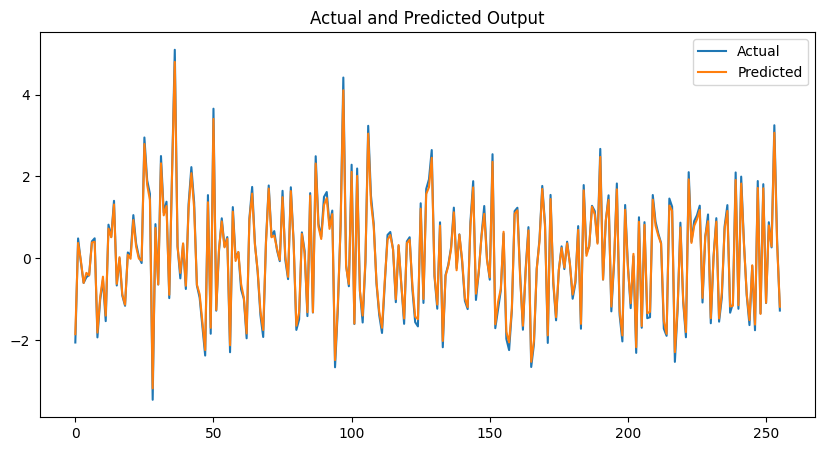

In [ ]:
import matplotlib.pyplot as plt

actual_output = output_data[1]
predicted_output = predictions[1]

# Построение графика
plt.figure(figsize=(10,5))

plt.title('Actual and Predicted Output')
plt.plot(actual_output, label='Actual')
plt.plot(predicted_output, label='Predicted')

plt.legend() 

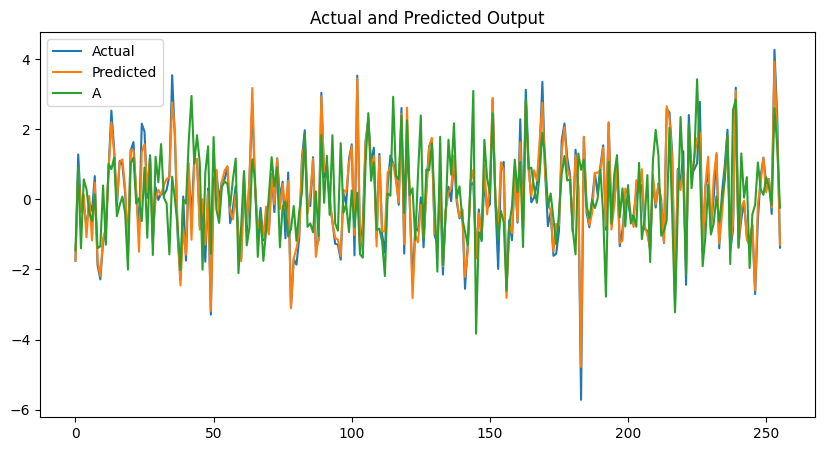

In [ ]:
import matplotlib.pyplot as plt
l=150
d=input_data[l]
actual_output = output_data[l]
predicted_output = predictions[l]

# Построение графика
plt.figure(figsize=(10,5))

plt.title('Actual and Predicted Output')
plt.plot(actual_output, label='Actual')
plt.plot(predicted_output, label='Predicted')
plt.plot(d, label='A')

plt.legend() 

In [ ]:
# Загрузка модели с весами
model.load_weights('/content/drive/MyDrive/mostvalid2001mod')

# Получение весов слоя встраивания
embeddings = model.embedding.get_weights()[0]

# Чтение файла и создание списка слов
with open('/content/train.txt', 'r') as file:
    text = file.read()
words = text.split()

# Создание словаря, связывающего каждое слово с его эмбеддингом
word2embedding = {word: embeddings[ids_from_chars([word]).numpy()[0]] for word in words}

# Теперь вы можете получить эмбеддинг любого слова, например:
word = '10'  # замените на любое слово в вашем тексте
print(f'Word: {word}')
print(f'Embedding: {word2embedding[word]}')


Word: 10
Embedding: [-1.13374159e-01  2.09030090e-03  4.84886467e-02 -1.85053617e-01
 -9.29663107e-02  2.09497824e-01 -2.26806089e-01  1.03064865e-01
 -4.27403934e-02 -2.66625494e-01 -8.29460993e-02 -6.66736737e-02
 -3.69371213e-02 -6.39281496e-02 -7.11373761e-02  1.38229847e-01
 -1.01986945e-01  2.87307560e-01  2.66070247e-01  7.50181898e-02
 -1.92659110e-01  1.51426405e-01 -3.86934757e-01 -1.91234186e-01
  1.96272448e-01  1.24184638e-01  1.43226206e-01  2.67362714e-01
  5.80290612e-03 -2.57100984e-02  1.71631455e-01 -2.71346152e-01
  7.54497945e-02 -9.74571258e-02 -1.76329002e-01  3.07184011e-01
  1.34607032e-01  2.46108174e-02 -4.43147364e-05 -1.01182014e-01
 -1.22296177e-01  1.68345600e-01  9.01174545e-02  3.46959010e-02
  1.61196768e-01  1.48044094e-01 -2.03844160e-01 -1.42294988e-01
 -1.58911079e-01 -3.08712751e-01 -1.66008323e-01 -2.05825567e-01
  1.21451288e-01  2.66822368e-01  2.42330432e-02 -1.25220165e-01
  1.98422283e-01  1.80198446e-01 -4.35209833e-02 -2.80287694e-02
  5.1

In [ ]:
word2embedding

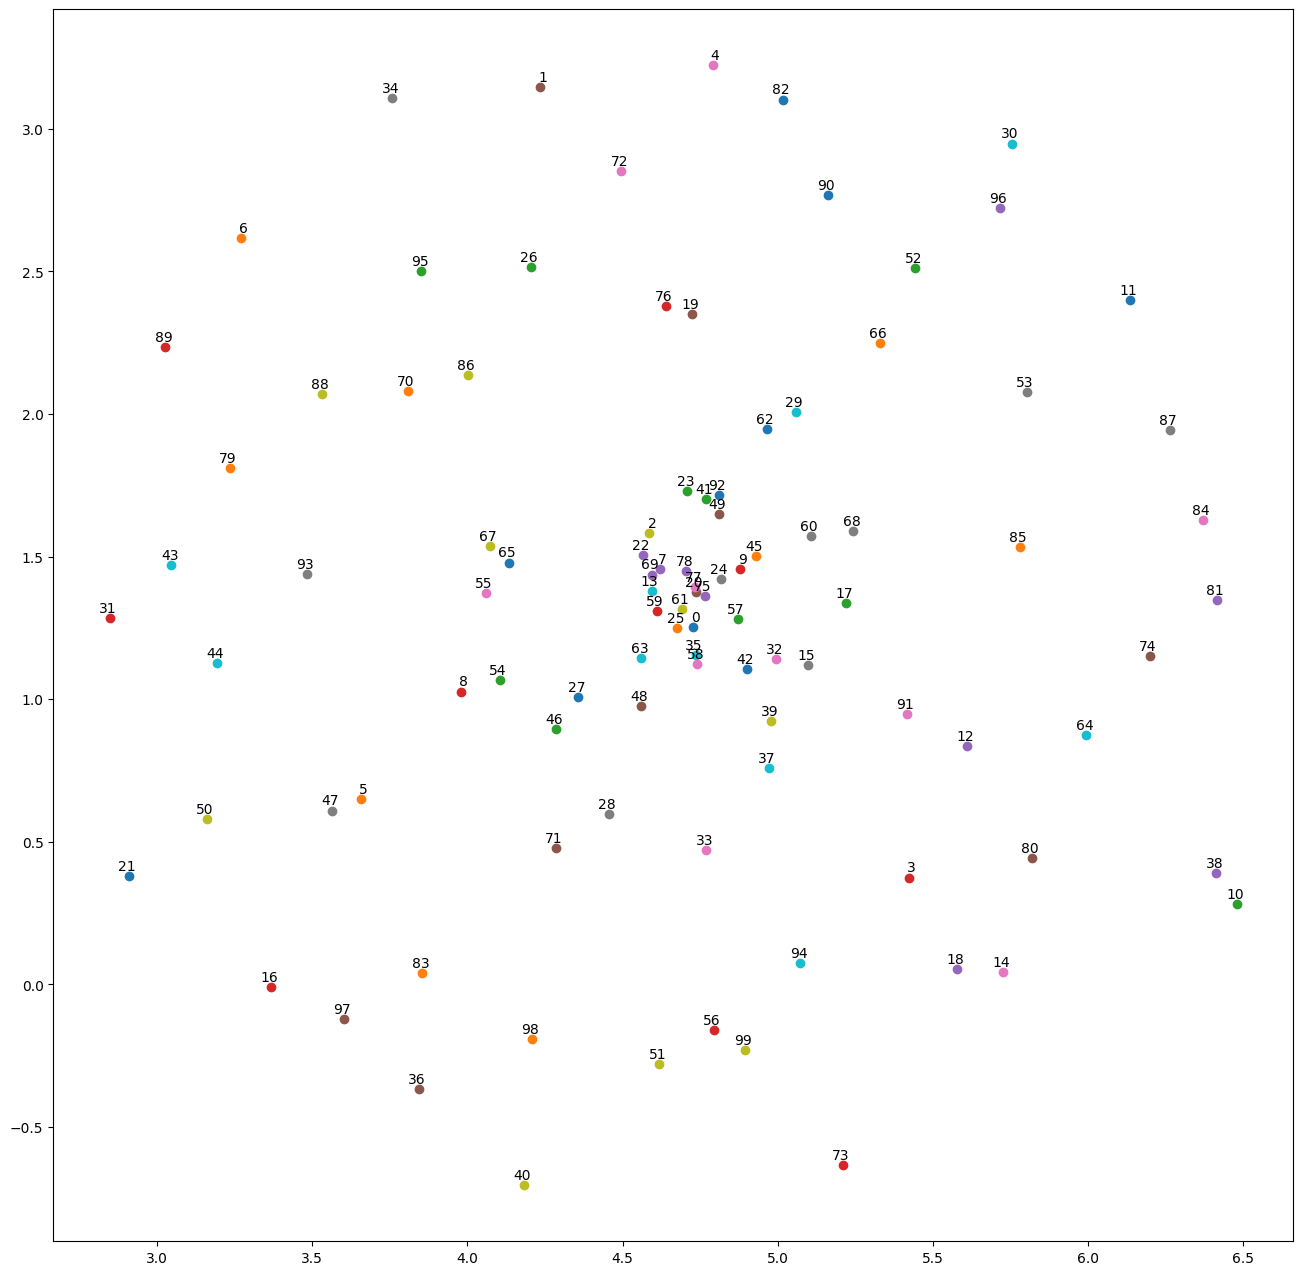

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import numpy as np

# преобразование списка в numpy массив
embeddings = np.array(embeddings)

# Теперь примените t-SNE


# Создание модели t-SNE и преобразование данных
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(embeddings)

# Создание графика
plt.figure(figsize=(16, 16)) 

for i, word in enumerate(word2embedding.keys()):
    plt.scatter(new_values[i][0], new_values[i][1])
    plt.annotate(word,
                 xy=(new_values[i][0], new_values[i][1]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()


In [ ]:
import pandas as pd

# Чтение файла CSV
df = pd.read_csv('/content/meangigzig20001.csv', header=0)  # Замените None на 0, если в файле есть заголовки

# Сортировка по первой колонке (индексация в pandas начинается с 0)

df = df.sort_values(by=['Cluster'])

# Умножение второй колонки на 10000
df['avg(y_diff)'] = df['avg(y_diff)'] * 100000
df['avg(y_diff)'] = df['avg(y_diff)'].apply(lambda x: str(x) )
pd.set_option('display.max_rows', None)
# Печать содержимого файла
print(df)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Функция для поиска наиболее похожих слов
def most_similar(word, word2embedding, top_k=5):
    # Получение эмбеддинга для данного слова
    word_embedding = word2embedding[word]
    
    # Вычисление косинусного сходства между эмбеддингом данного слова и эмбеддингами всех остальных слов
    similarities = {}
    for other_word, other_embedding in word2embedding.items():
        similarity = cosine_similarity([word_embedding], [other_embedding])[0][0]
        similarities[other_word] = similarity

    # Сортировка слов по убыванию сходства и возврат top_k наиболее похожих
    sorted_similarities = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
    most_similar_words = [word for word, similarity in sorted_similarities[:top_k]]
    
    return most_similar_words

# Тестирование функции
word = '5'  # замените на любое слово в вашем тексте
similar_words = most_similar(word, word2embedding)
print(f'Most similar words to "{word}": {similar_words}')

Most similar words to "5": ['5', '50', '21', '93', '47']


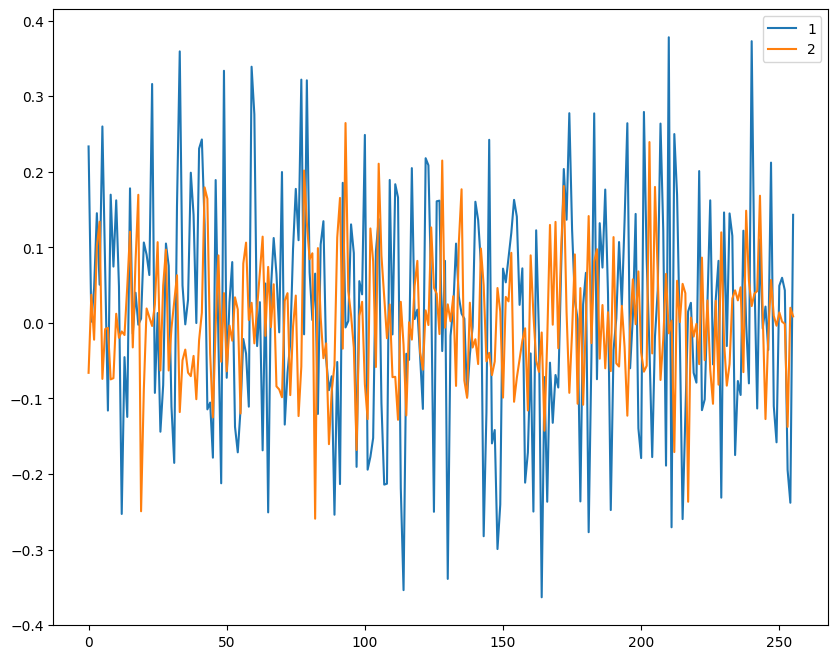

In [ ]:
import matplotlib.pyplot as plt

# Выберите несколько слов для визуализации
words_to_visualize = ['1', '2']  # замените на слова из вашего текста

# Создайте новый график
plt.figure(figsize=(10, 8))

# Для каждого выбранного слова
for word in words_to_visualize:
    # Получите соответствующий эмбеддинг
    embedding = word2embedding[word]
    # Выведите его на график
    plt.plot(embedding, label=word)

# Добавьте легенду и показать график
plt.legend()
plt.show()

## Generate text

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, words_from_ids, ids_from_words, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.words_from_ids = words_from_ids
    self.ids_from_words = ids_from_words

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_words(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_words.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_words = tf.strings.split(inputs, ' ')
    input_ids = self.ids_from_words(input_words).to_tensor()

    # Run the model.
    predicted_logits, states = self.model(inputs=input_ids, states=states, return_state=True)
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_words = self.words_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_words, states


In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)  

NameError: ignored

Run it in a loop to generate some text. Looking at the generated text, you'll see the model knows when to capitalize, make paragraphs and imitates a Shakespeare-like writing vocabulary. With the small number of training epochs, it has not yet learned to form coherent sentences.

In [ ]:
import re

start = time.time()
states = None
next_word = tf.constant(['1 2 3'])  # starting words
result = [next_word]

for n in range(1000):
  next_word, states = one_step_model.generate_one_step(next_word, states=states)
  result.append(next_word)

# join the words with a space
result = tf.strings.join(result, separator=' ')
end = time.time()

# use regular expressions to split the result into words
result_words = re.findall(r'\b\w+\b', result[0].numpy().decode('utf-8'))

print(result_words, '\n\n' + '_'*80)
print('\nRun time:', end - start)

['1', '2', '3', '61', '69', '43', '77', '78', '60', '66', '92', '22', '61', '48', '17', '29', '32', '20', '86', '32', '20', '78', '98', '69', '49', '45', '76', '0', '37', '59', '63', '9', '78', '42', '68', '75', '13', '35', '69', '61', '55', '92', '78', '13', '86', '32', '0', '20', '68', '2', '8', '57', '7', '61', '2', '67', '77', '55', '85', '61', '42', '75', '59', '77', '2', '92', '35', '61', '12', '32', '76', '54', '29', '68', '66', '62', '2', '22', '32', '59', '45', '69', '92', '61', '77', '13', '22', '35', '54', '2', '17', '55', '0', '57', '58', '61', '56', '32', '37', '20', '7', '63', '42', '49', '65', '63', '17', '23', '3', '39', '61', '92', '77', '61', '59', '0', '92', '61', '69', '49', '27', '37', '20', '78', '57', '59', '13', '58', '57', '66', '19', '0', '28', '62', '63', '59', '27', '39', '57', '25', '50', '55', '59', '20', '22', '61', '61', '76', '60', '62', '78', '8', '22', '71', '2', '77', '29', '42', '61', '59', '41', '75', '22', '61', '39', '61', '25', '46', '69', '78',

In [ ]:
import re


In [ ]:
tf.saved_model.save(one_step_model, '/content/drive/MyDrive/mostvalid2001')

NameError: ignored

In [ ]:
model.save('/content/drive/MyDrive/mostvalid2001mod')

## Export the generator

This single-step model can easily be [saved and restored](https://www.tensorflow.org/guide/saved_model), allowing you to use it anywhere a `tf.saved_model` is accepted.

In [ ]:
tf.saved_model.save(one_step_model, '/content/drive/MyDrive/zig')
one_step_reloaded = tf.saved_model.load('/content/drive/MyDrive/zig200012000_3')

OSError: ignored

In [ ]:
one_step_reloaded = tf.saved_model.load('/content/drive/MyDrive/mostvalid2001')

In [ ]:
model.save('/content/drive/MyDrive/20001emb')

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the file
file_path = '/content/test.txt'
with open(file_path, "r") as f:
    text = f.read()
means12 = pd.read_csv('/content/meangigzig20001.csv')

# Split the text into numbers and create a list
numbers = text.split()
n = 6000

# Create 2D lists to store each cycle's x and y points
input_points_x_all, input_points_y_all = [], []
output_points_x_all, output_points_y_all = [], []

iteration = 0
while n + 50 < len(numbers) and iteration < 1:
    for k in range(200):
      input_text = ' '.join(numbers[n:n + 100])
      states = None
      next_char = tf.constant([input_text])
      result = [next_char]

      for i in range(100):
          next_char, states = one_step_model.generate_one_step(next_char, states=states)
          
          result.append(next_char)

      result = tf.strings.join(result, separator=' ')

      # Use regular expressions to split the result into words
      output_text = re.findall(r'\b\w+\b', result[0].numpy().decode('utf-8'))

      # Process clusters and generate points
      input_clusters = list(map(int, ' '.join(numbers[n:n + 200]).split()))
      output_clusters = list(map(int, output_text))
      input_points = process_clusters(input_clusters, means12)
      output_points = process_clusters(output_clusters, means12)

      # Extract x and y points
      input_points_x, input_points_y = zip(*input_points)
      output_points_x, output_points_y = zip(*output_points)

      # Add points from this cycle to the 2D list
      input_points_x_all.append(input_points_x)
      input_points_y_all.append(input_points_y)
      output_points_x_all.append(output_points_x)
      output_points_y_all.append(output_points_y)

      iteration += 1

# Convert the 2D lists to numpy arrays
input_points_x_all = np.array(input_points_x_all)
input_points_y_all = np.array(input_points_y_all)
output_points_x_all = np.array(output_points_x_all)
output_points_y_all = np.array(output_points_y_all)

# Calculate the mean of each point across all cycles
input_points_x_mean = input_points_x_all.mean(axis=0)
input_points_y_mean = input_points_y_all.mean(axis=0)
output_points_x_mean = output_points_x_all.mean(axis=0)
output_points_y_mean = output_points_y_all.mean(axis=0)

# Plot the mean points
plt.figure(figsize=(10,5))
plt.plot(input_points_x_mean, input_points_y_mean, label='Input Mean')
plt.plot(output_points_x_mean, output_points_y_mean, label='Output Mean')

plt.xlabel('Element Index')
plt.ylabel('Mean_Close_Open')
plt.title('Mean_Close_Open for Input and Output')
plt.legend()
plt.show()


NameError: ignored

In [ ]:
Воспроизведение с сумированием 20

<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


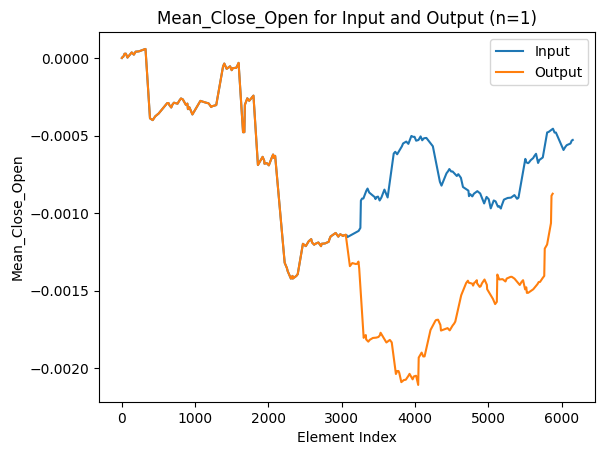

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


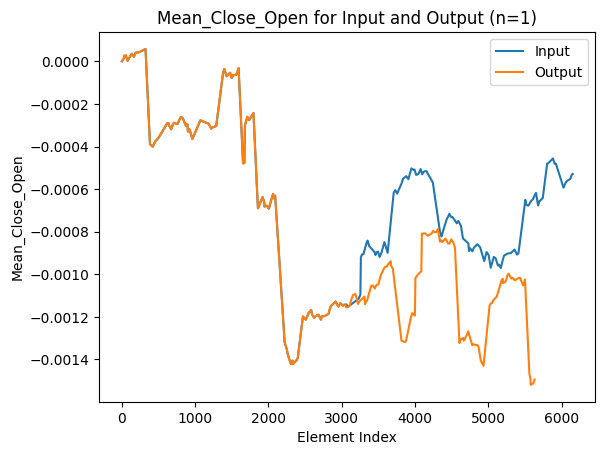

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.870081662961892e-07


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


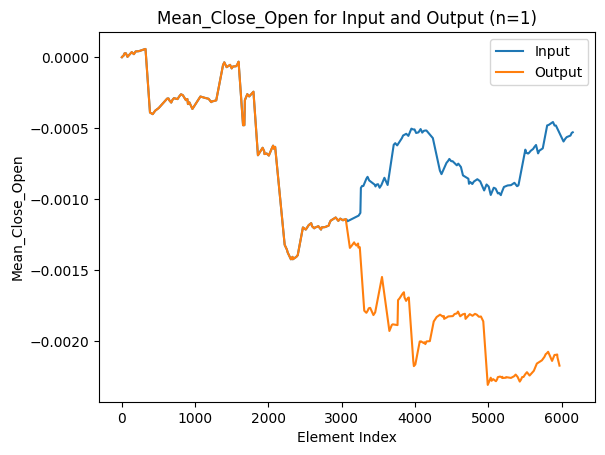

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.1866013071895393e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


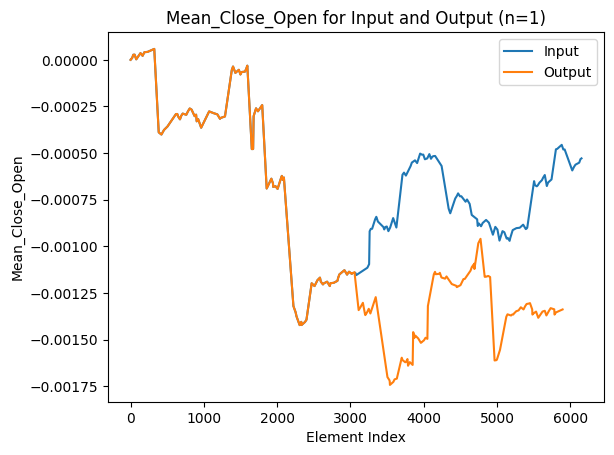

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.203608821563044e-06


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


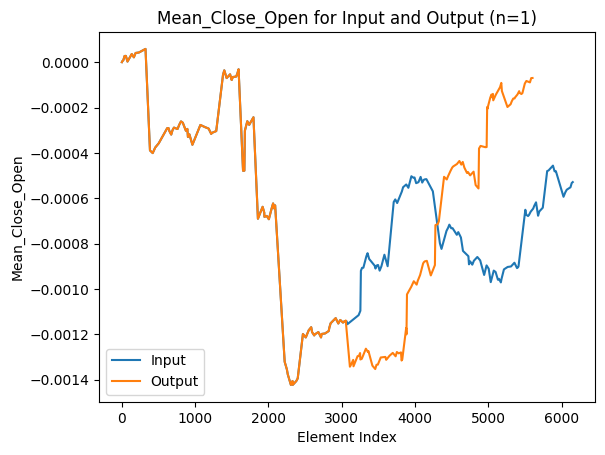

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


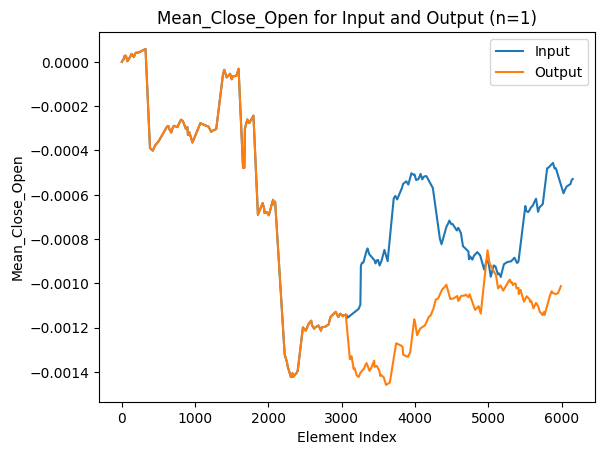

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  -1.2732657833204204e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


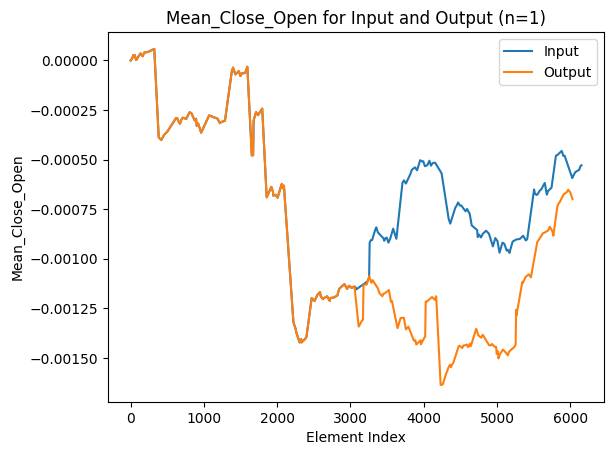

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


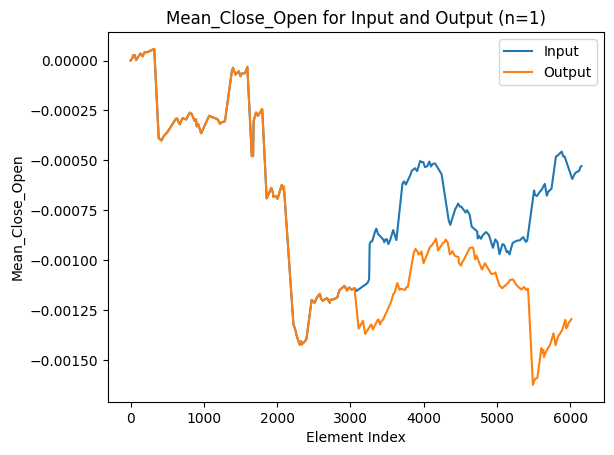

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  -5.912180656934178e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


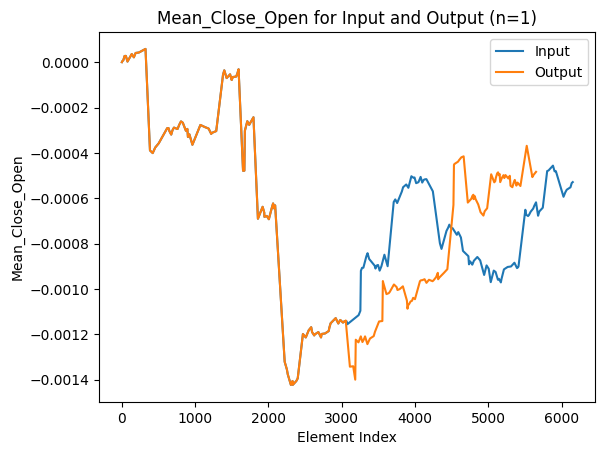

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


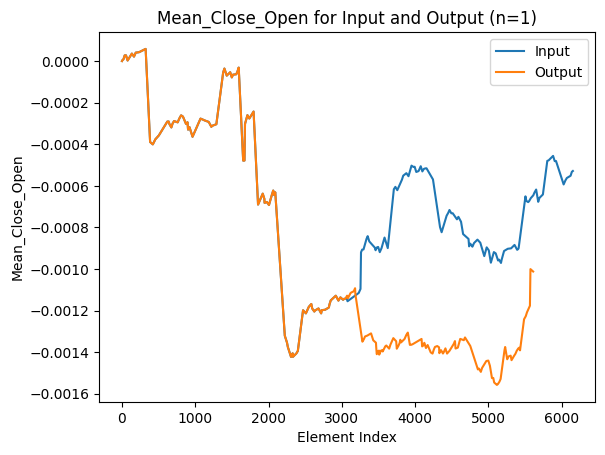

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


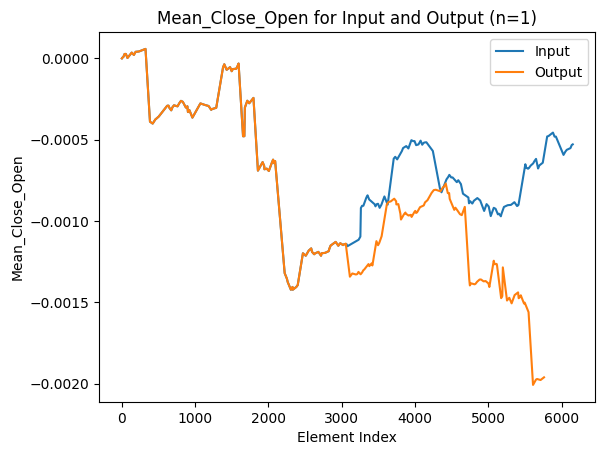

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


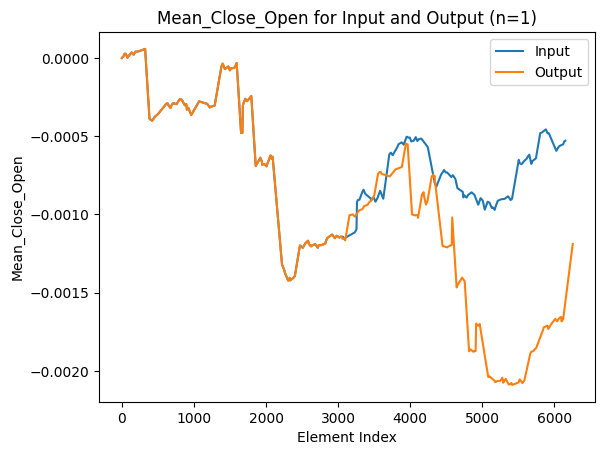

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.44710912809067e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


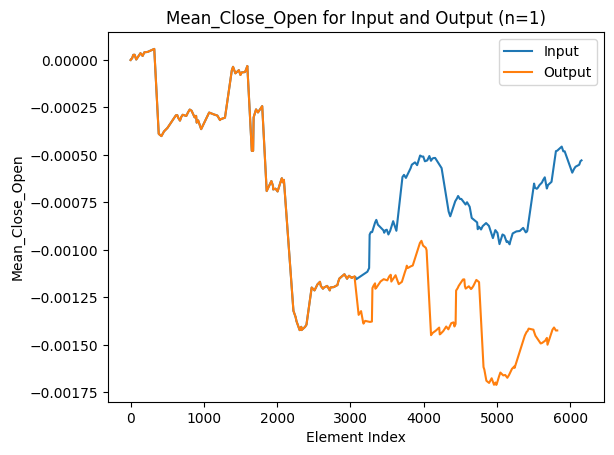

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  -1.2732657833204204e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


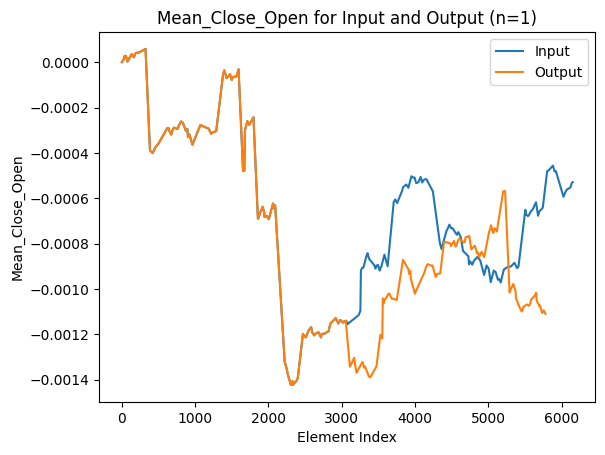

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.44710912809067e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


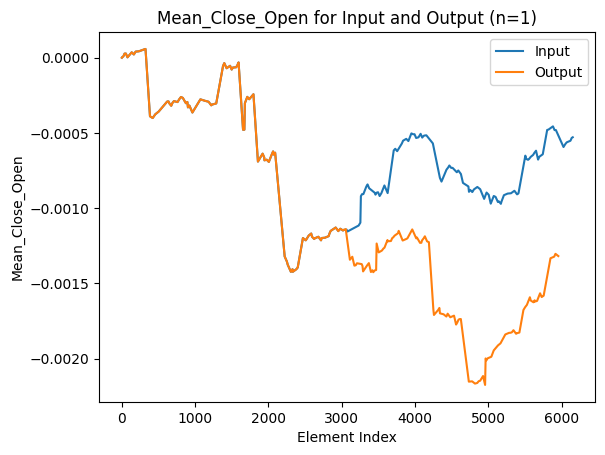

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  -5.912180656934178e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


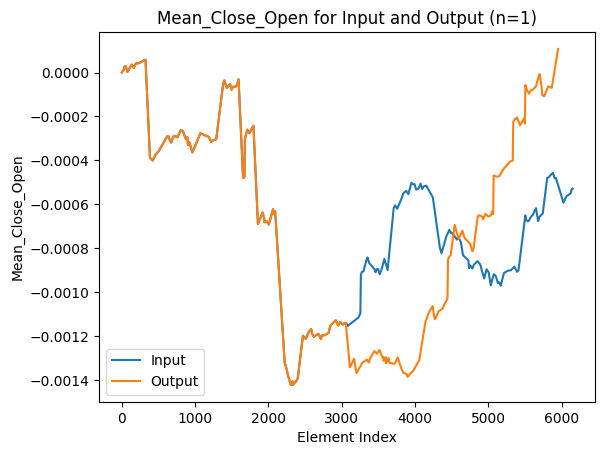

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


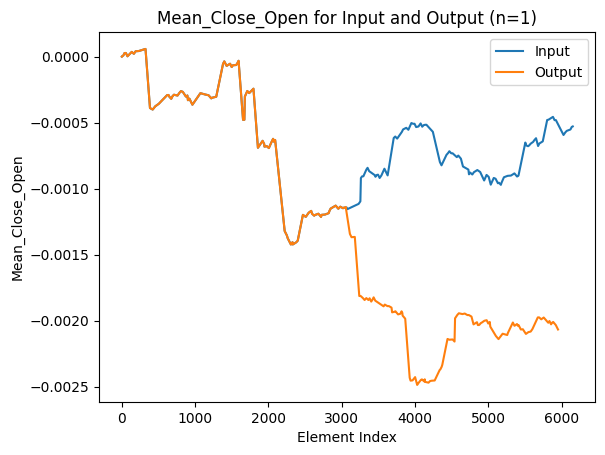

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.870081662961892e-07


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


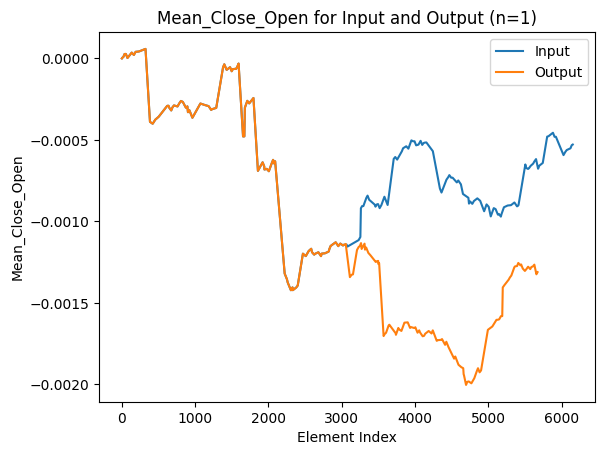

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  2.648365598224052e-06


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


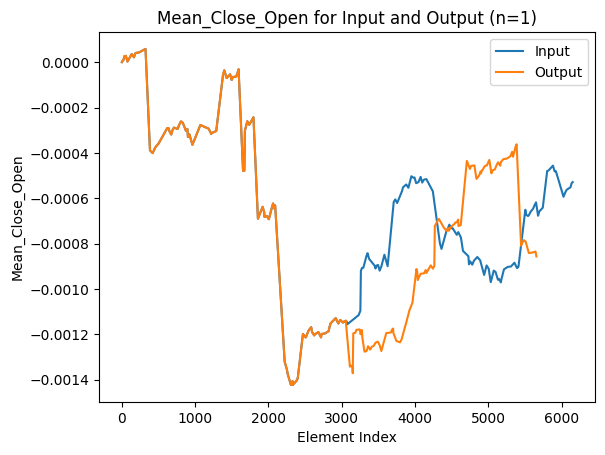

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.1866013071895393e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


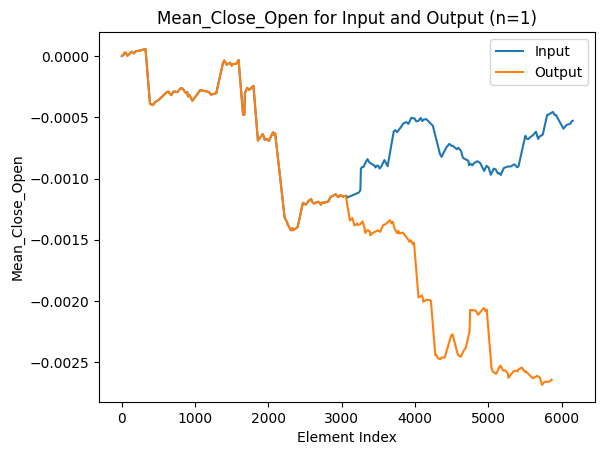

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


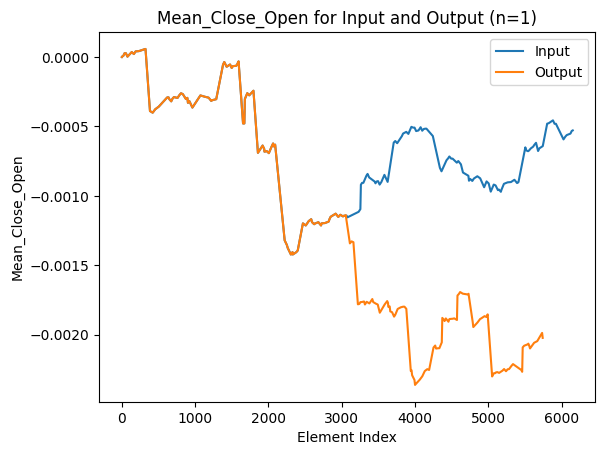

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.870081662961892e-07


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


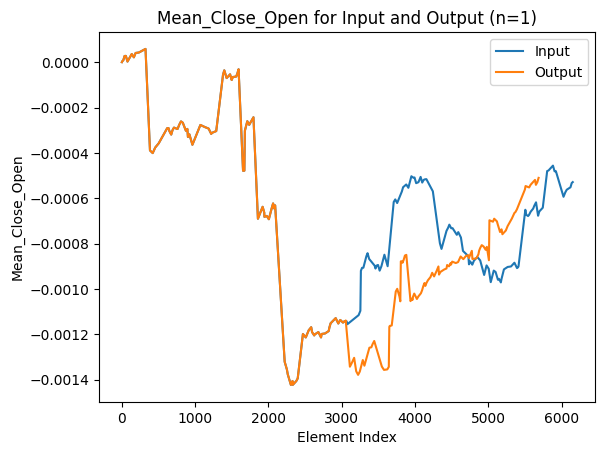

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


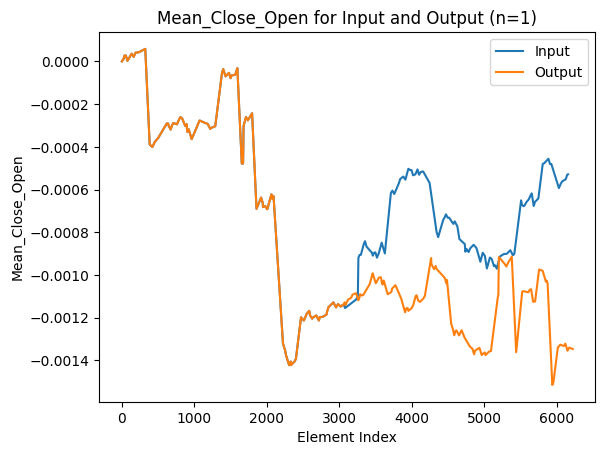

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  -1.2732657833204204e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


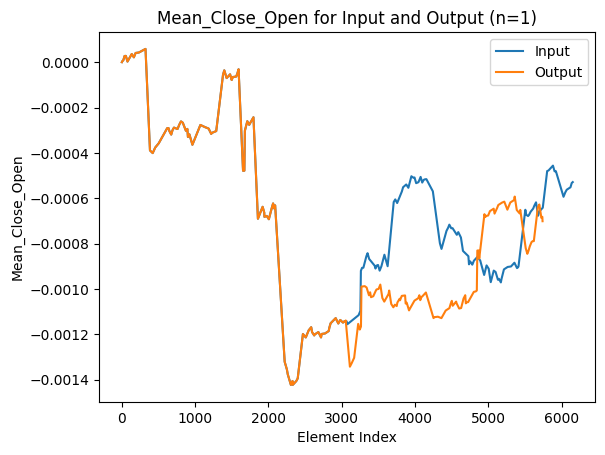

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  0.0001760828214781


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


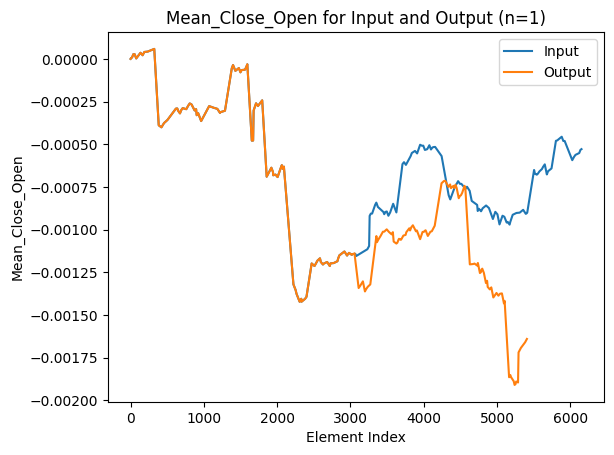

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


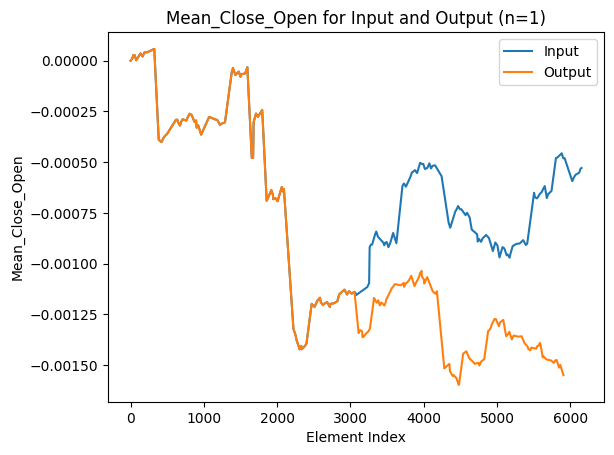

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


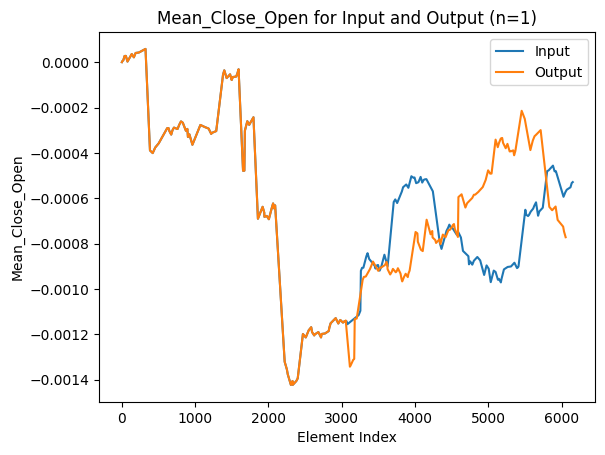

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.44710912809067e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


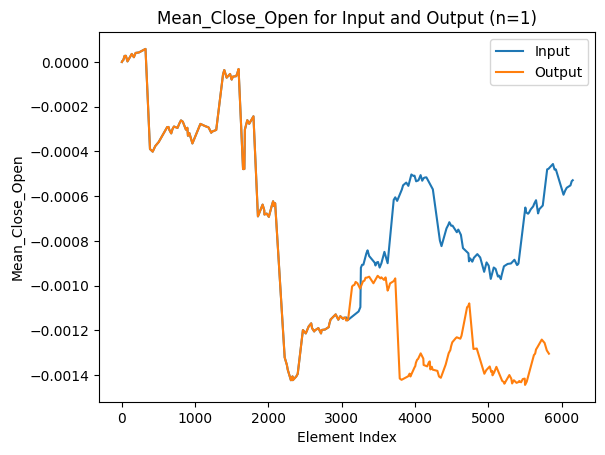

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


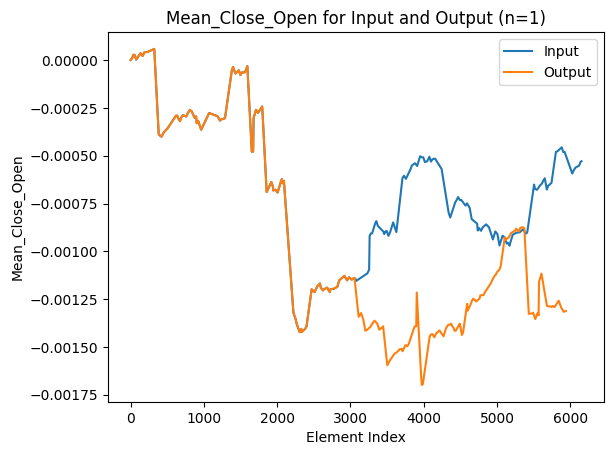

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


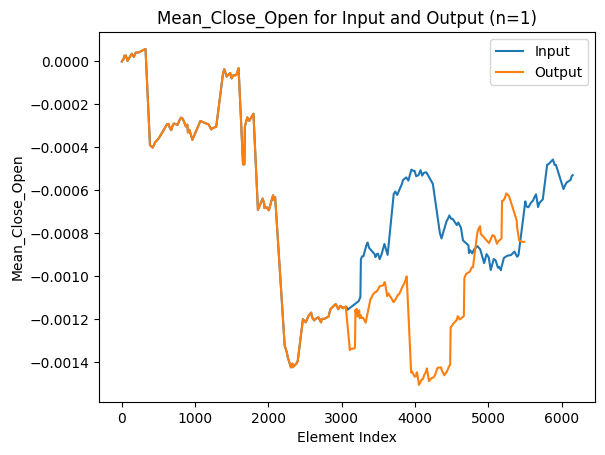

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.889651058753281e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


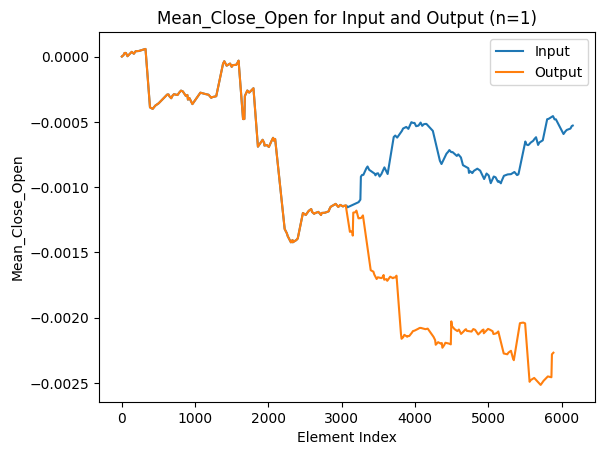

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  -3.583317642628544e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


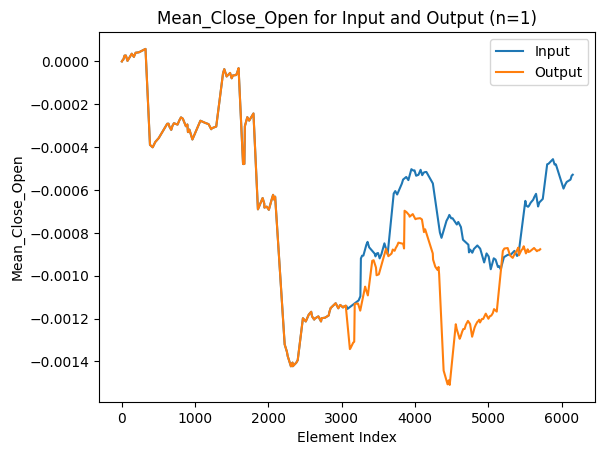

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


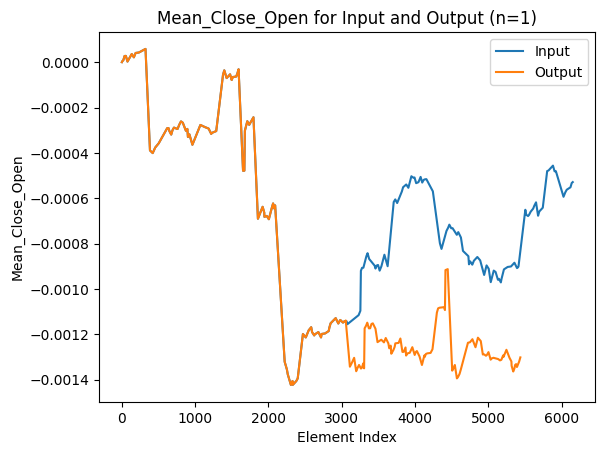

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.889651058753281e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


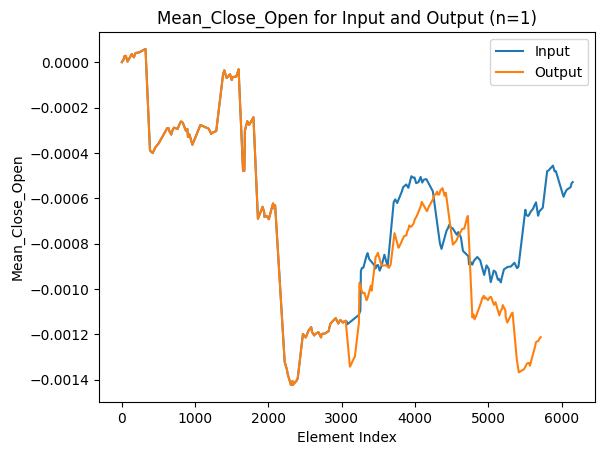

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.44710912809067e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


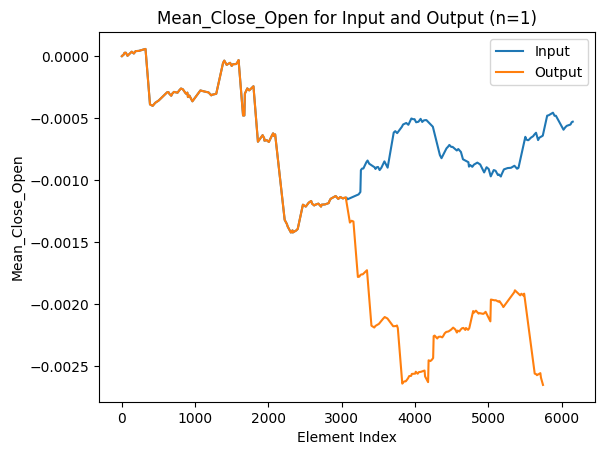

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


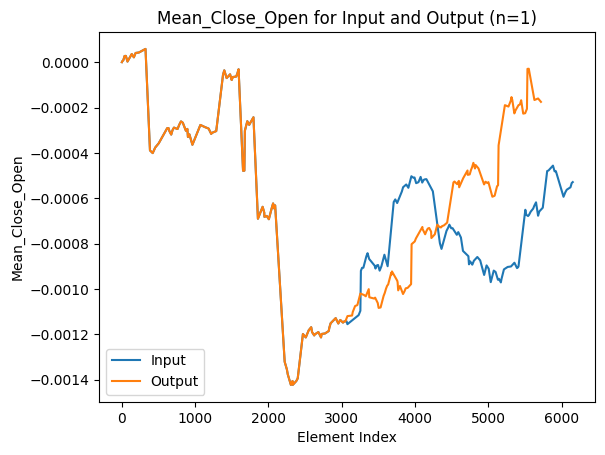

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


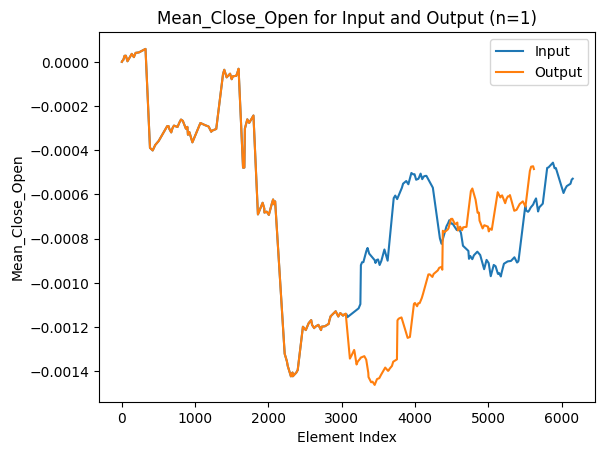

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.054494298830456e-06


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


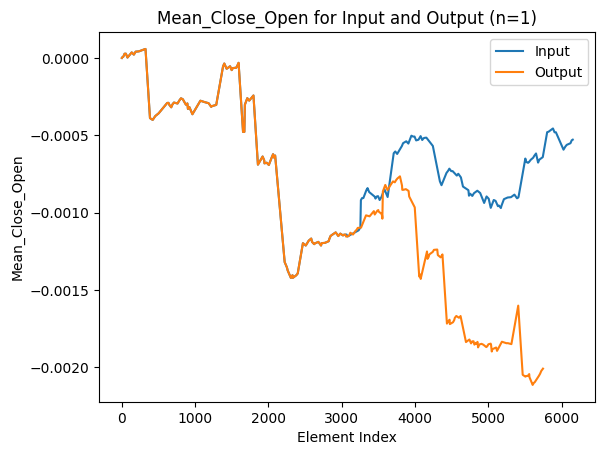

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


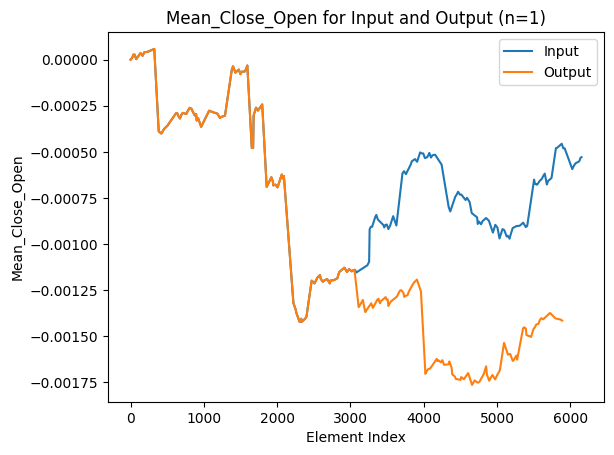

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.870081662961892e-07


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


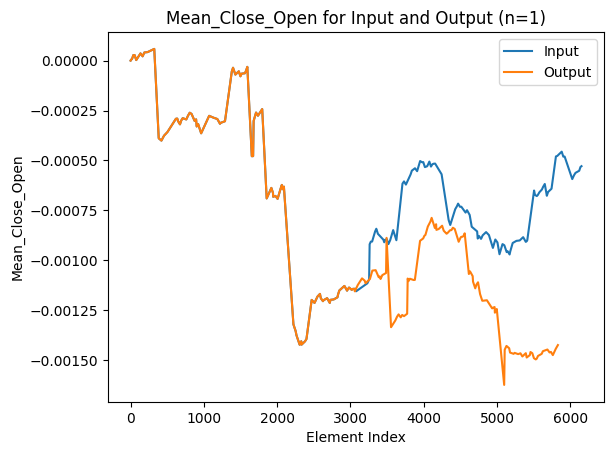

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.054494298830456e-06


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


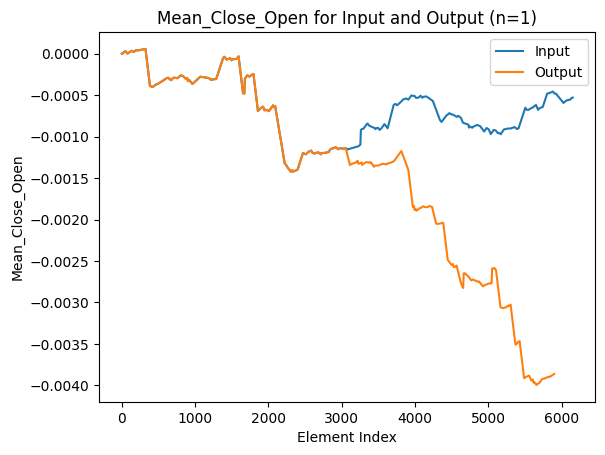

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


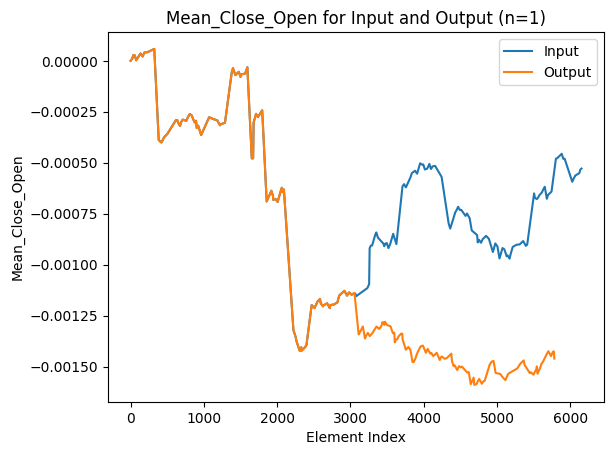

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.054494298830456e-06


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


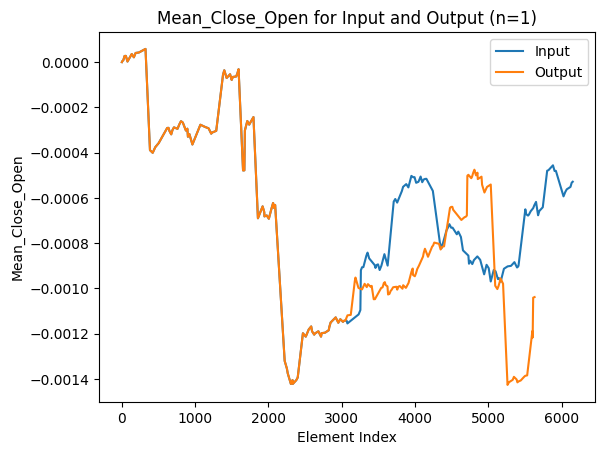

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


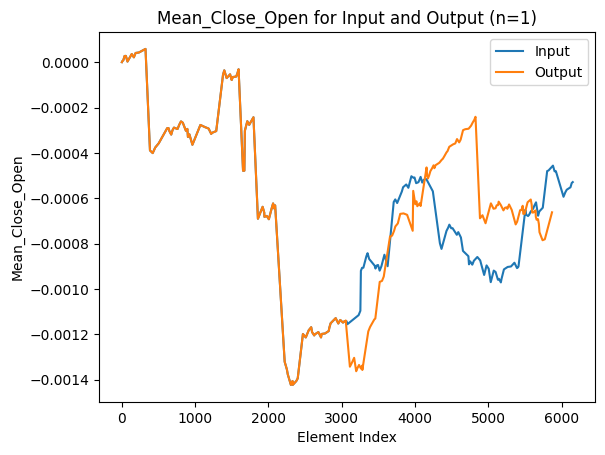

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.870081662961892e-07


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


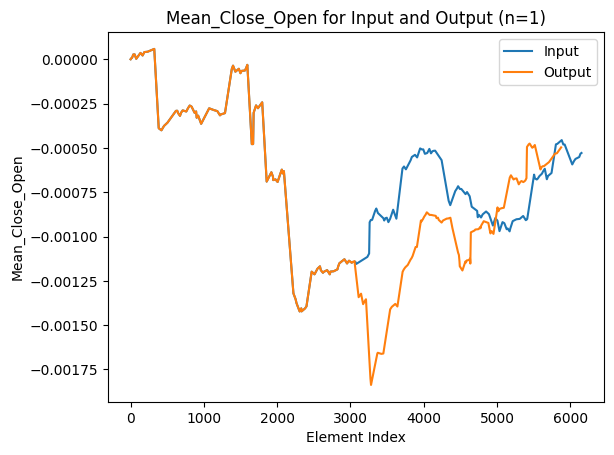

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


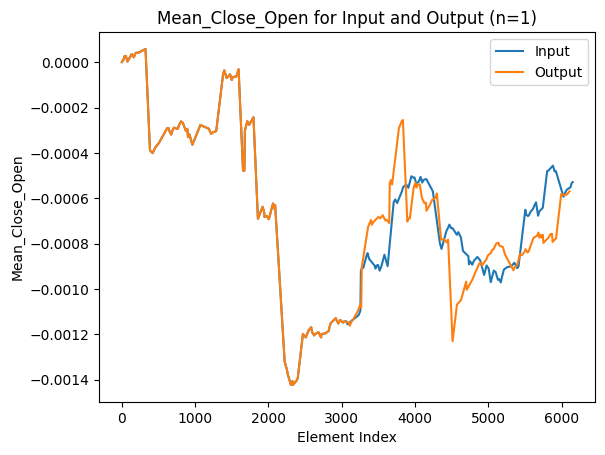

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


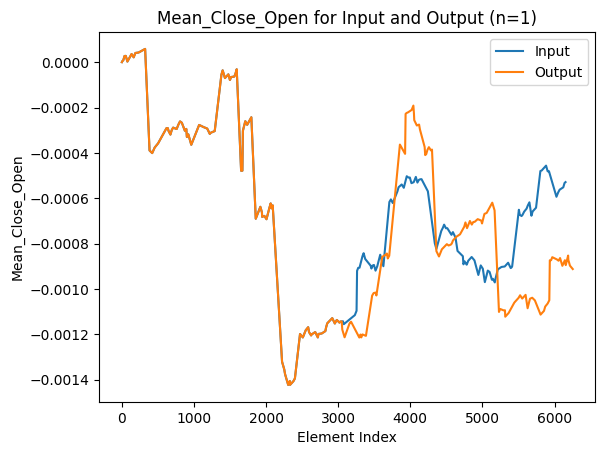

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.648976497346408e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


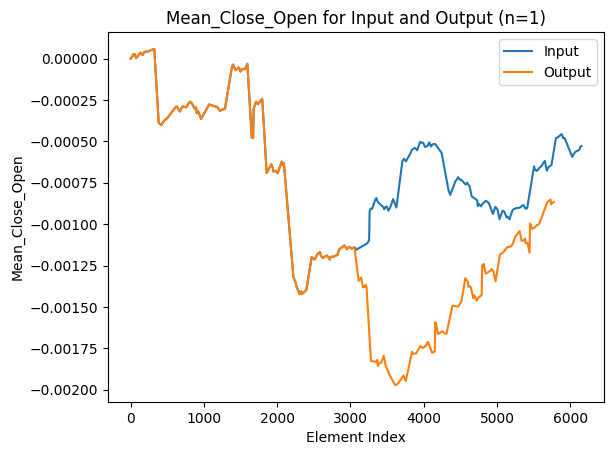

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  -5.912180656934178e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


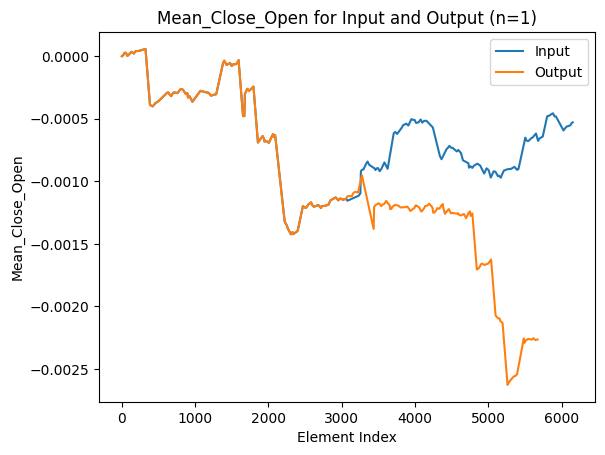

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


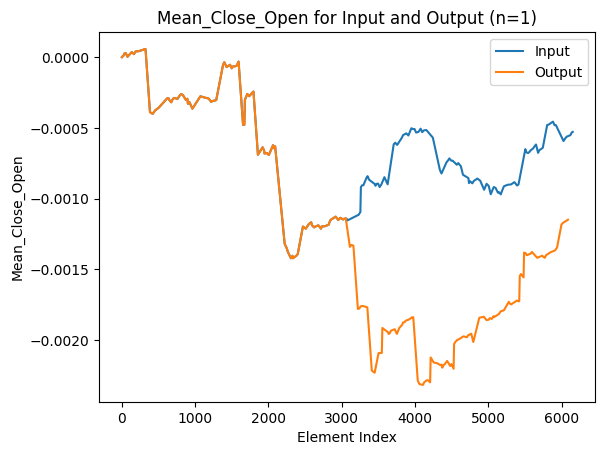

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.054494298830456e-06


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


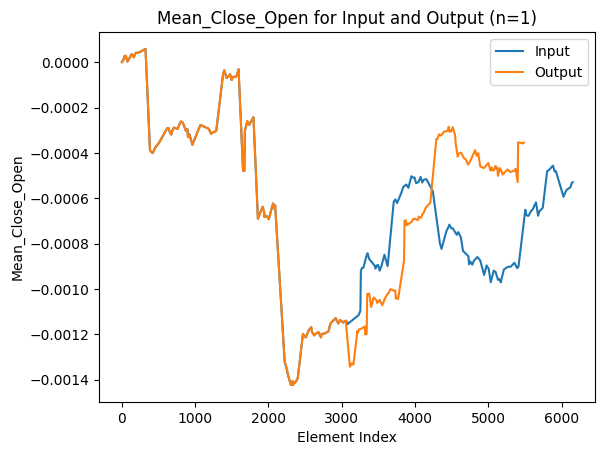

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.870081662961892e-07


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


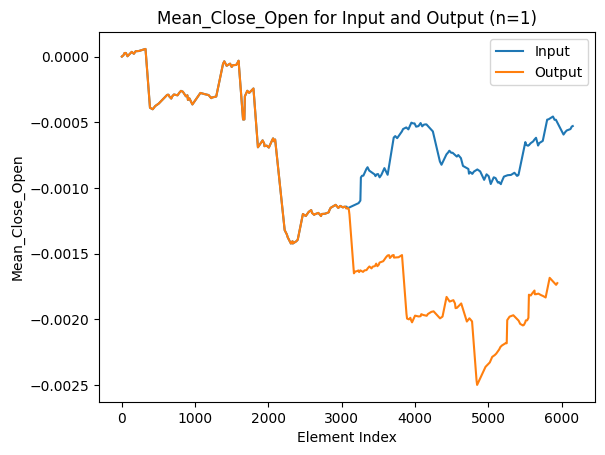

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


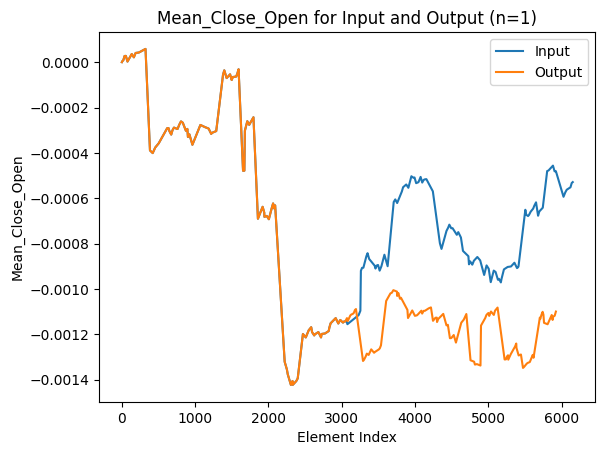

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


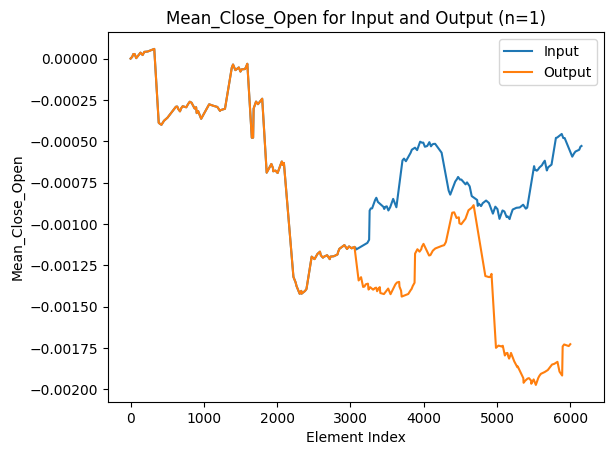

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


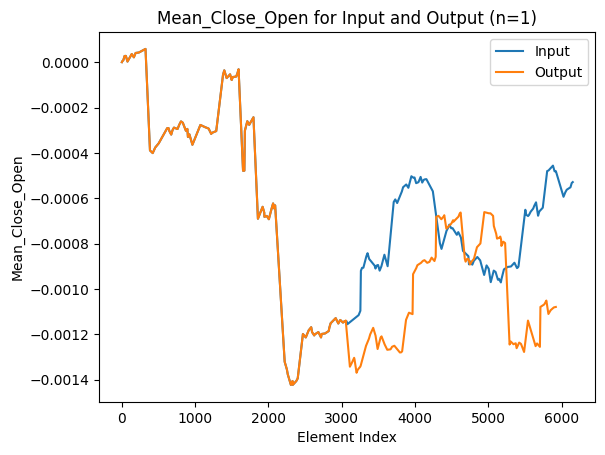

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.203608821563044e-06


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


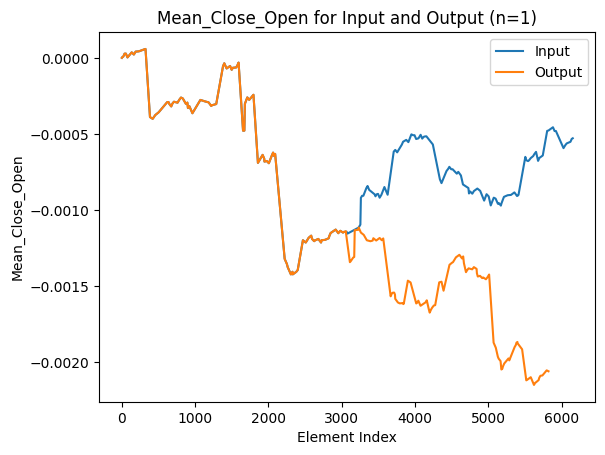

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


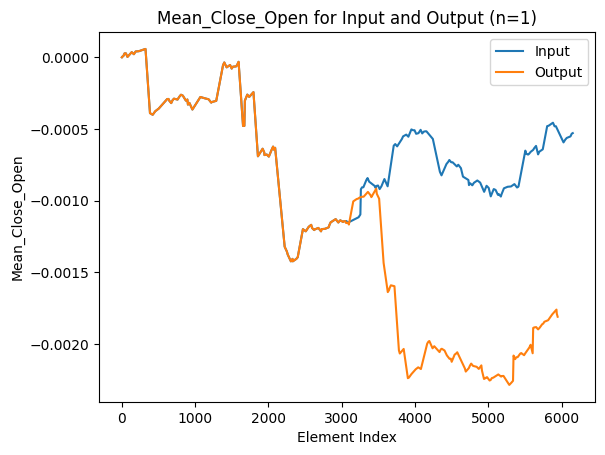

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.054494298830456e-06


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


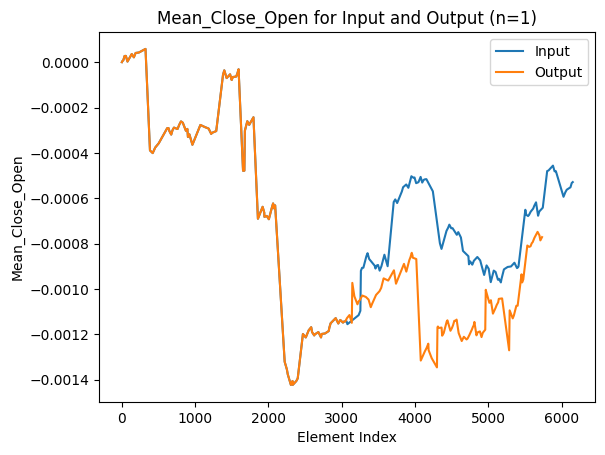

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.44710912809067e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


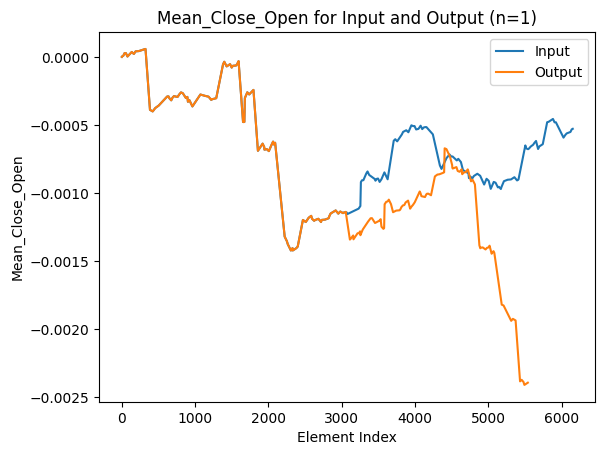

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  -6.742696053309425e-06


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


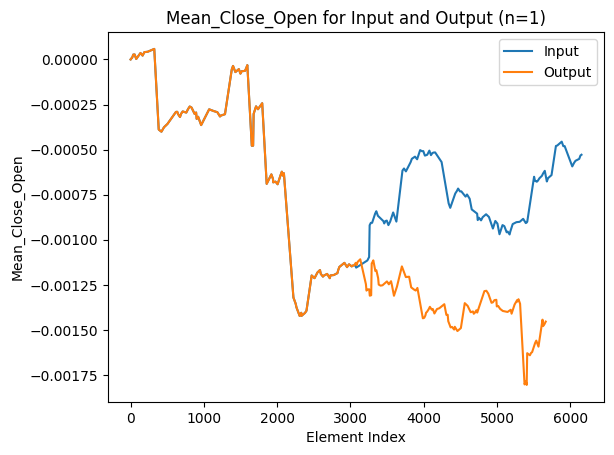

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  -3.583317642628544e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


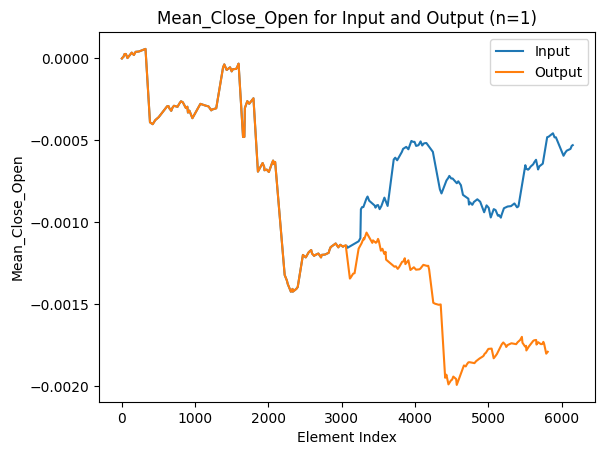

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.1447527141135444e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


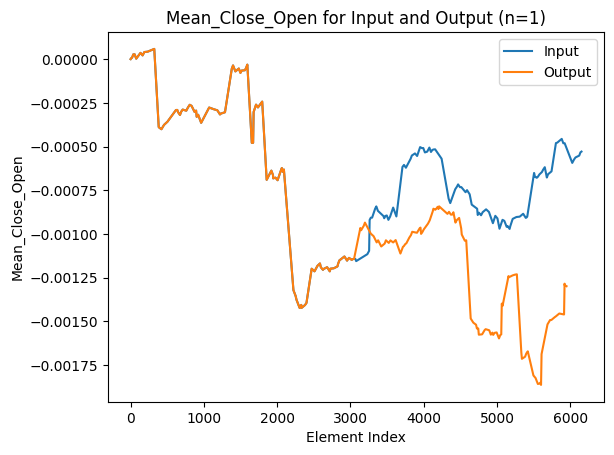

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.889651058753281e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


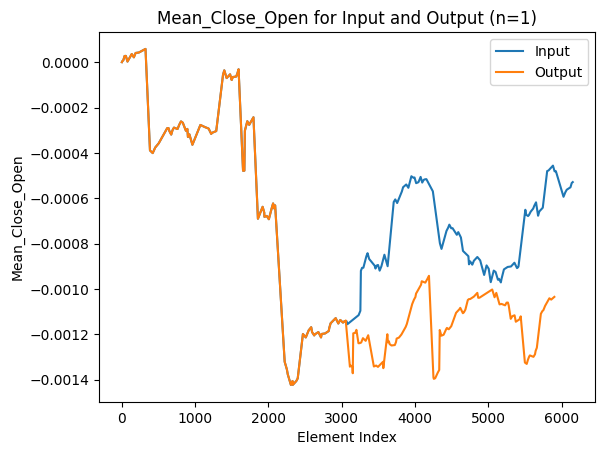

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.5396743787490948e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


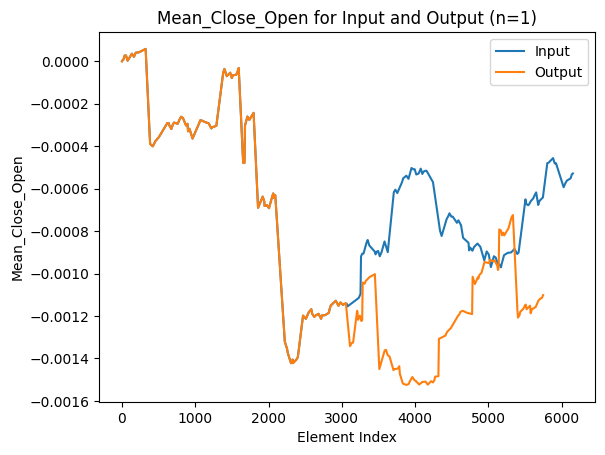

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  0.0001760828214781


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


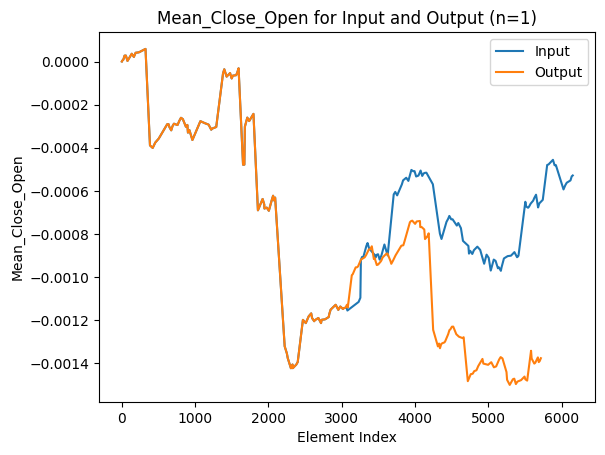

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


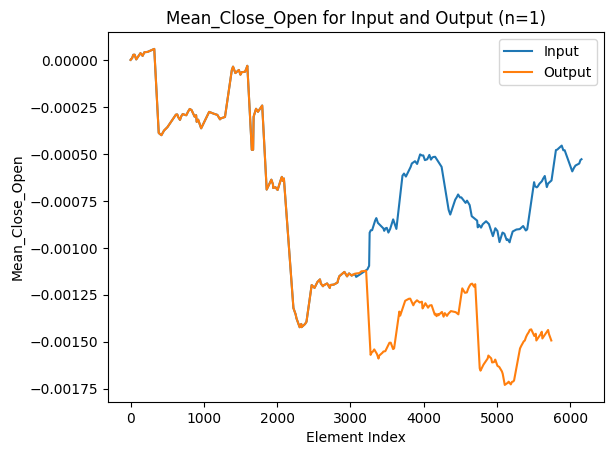

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


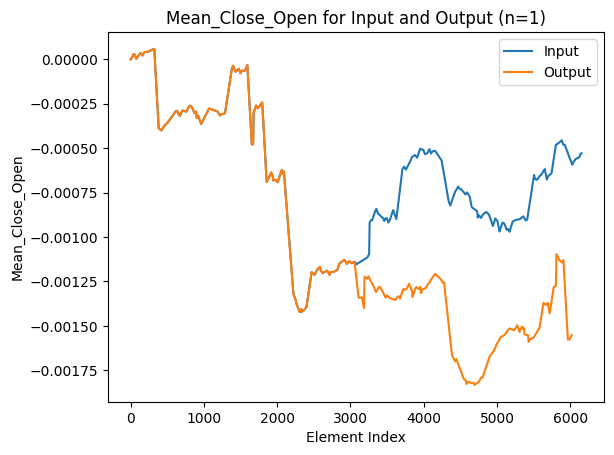

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


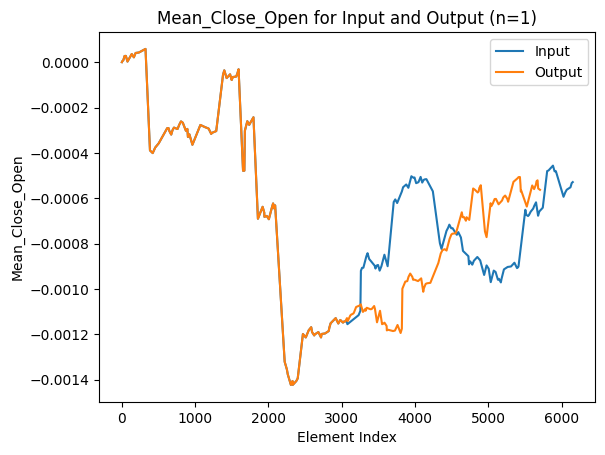

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.054494298830456e-06


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


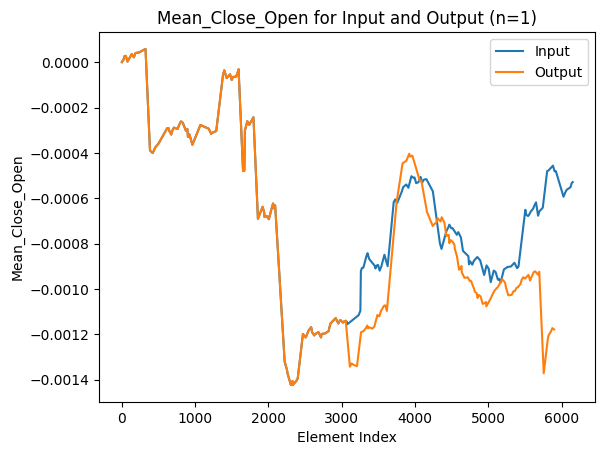

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  -5.9586316626895135e-06


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


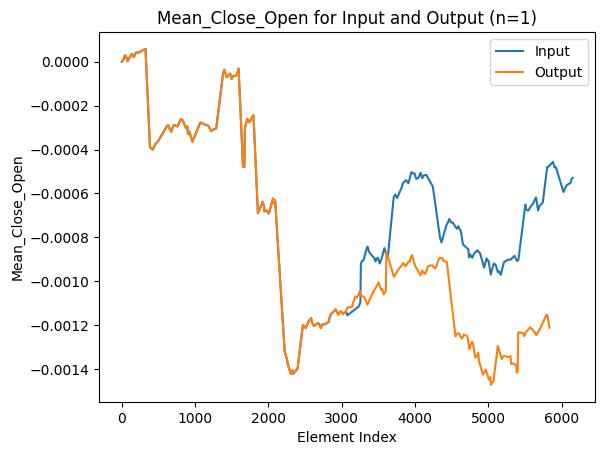

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  -1.2732657833204204e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


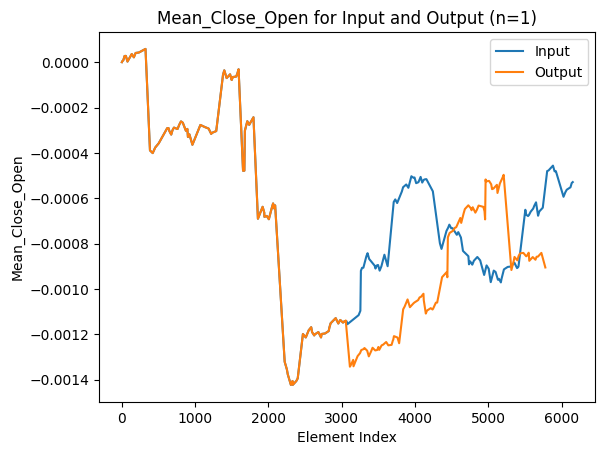

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.648976497346408e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


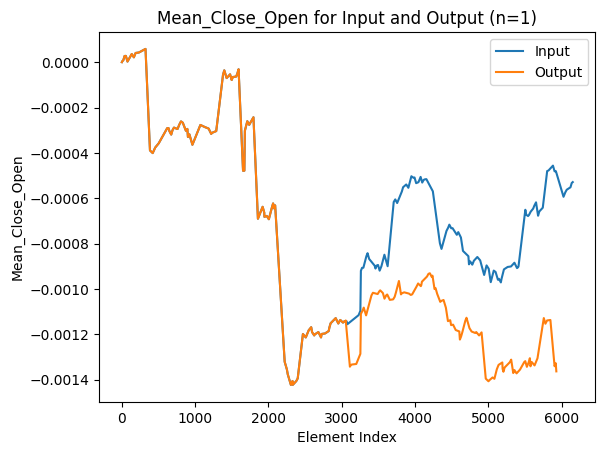

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.889651058753281e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


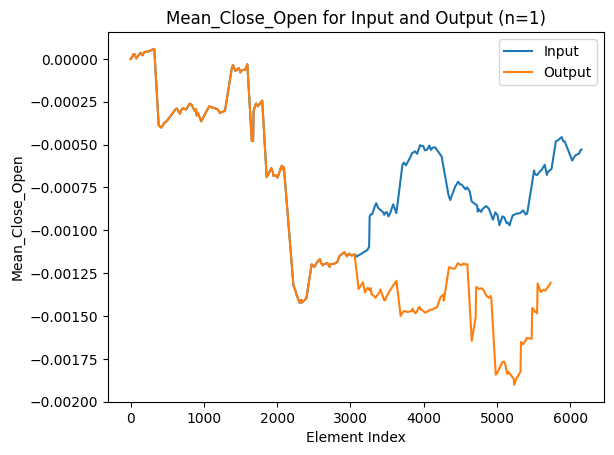

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


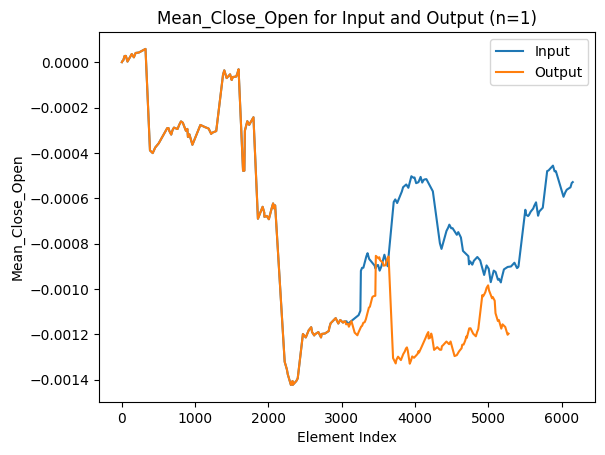

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


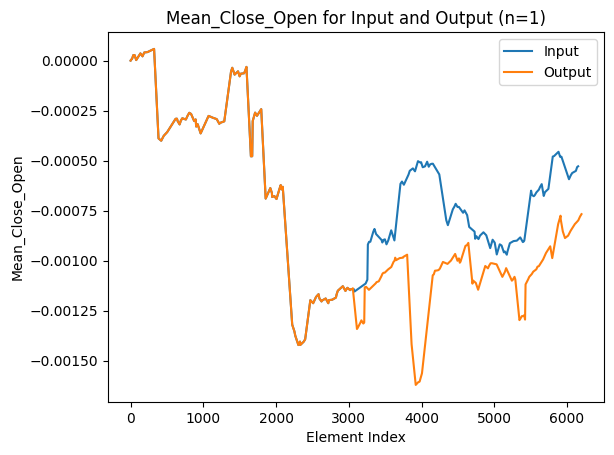

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.206939281288688e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


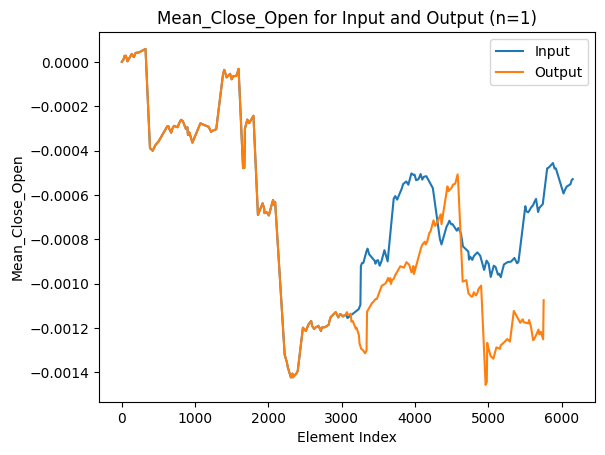

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  -3.583317642628544e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


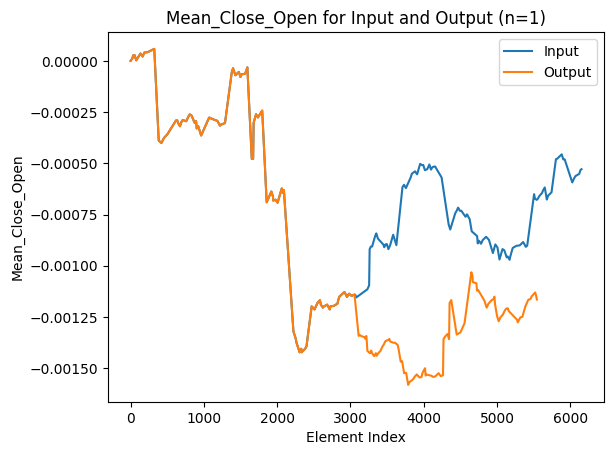

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


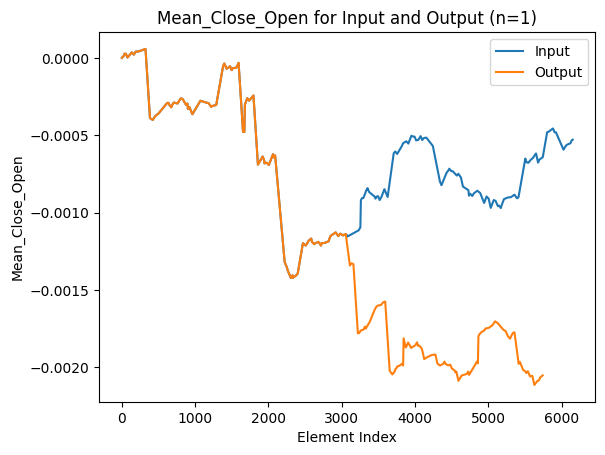

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


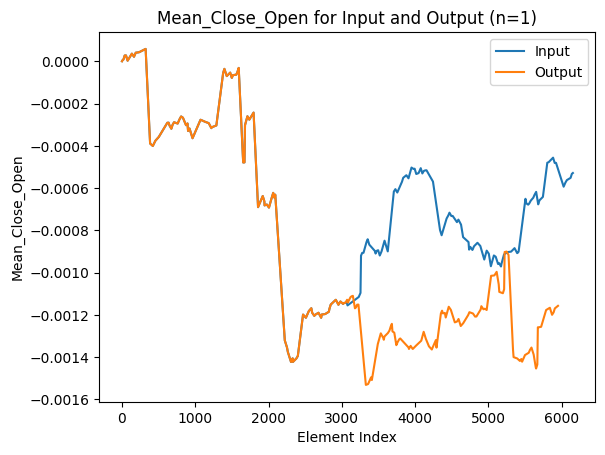

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


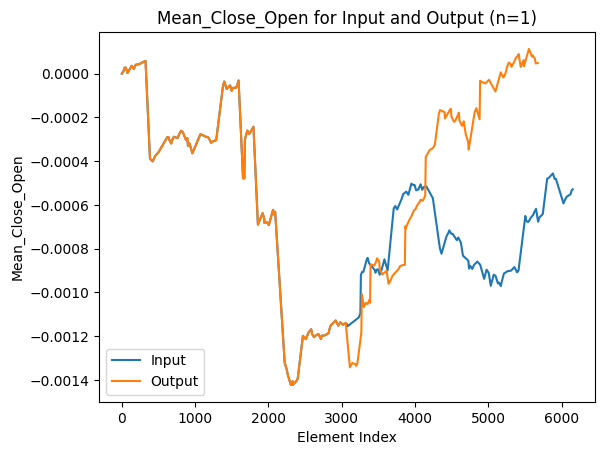

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.44710912809067e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


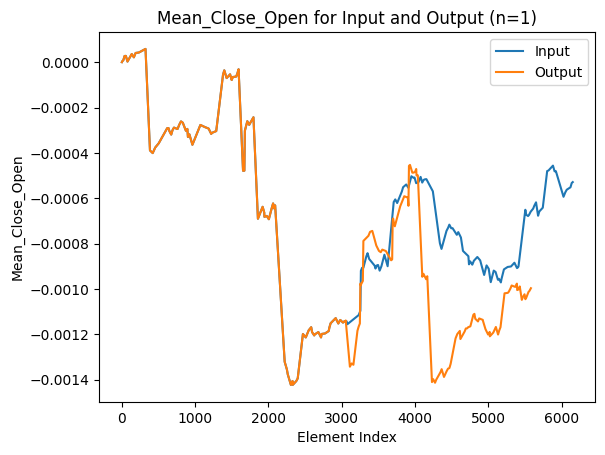

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


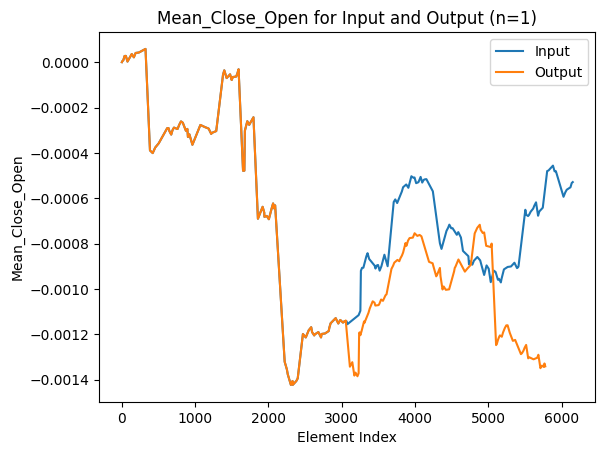

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


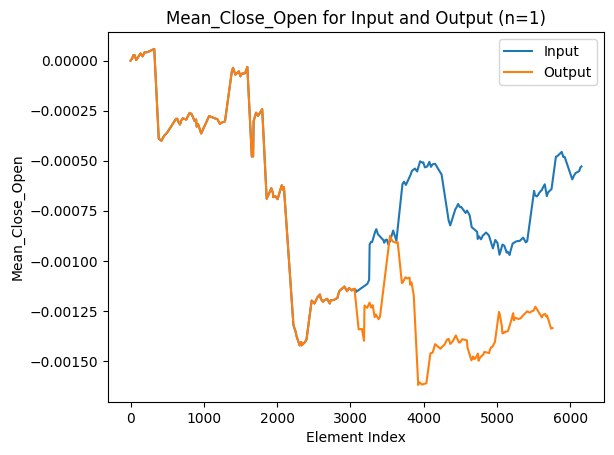

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


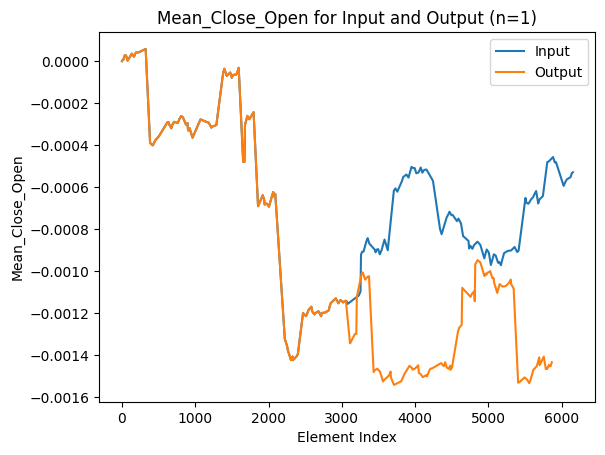

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  -1.933212176283385e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


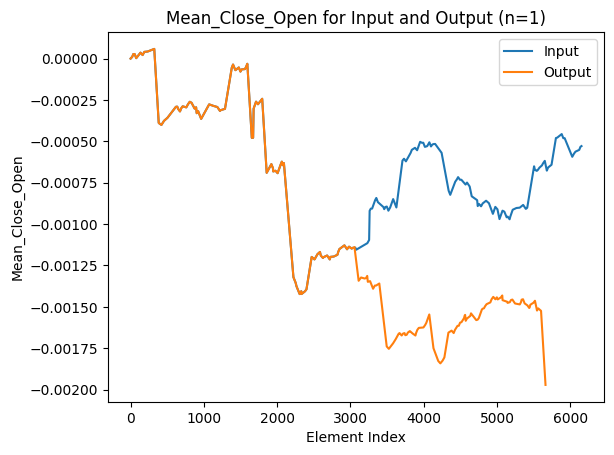

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


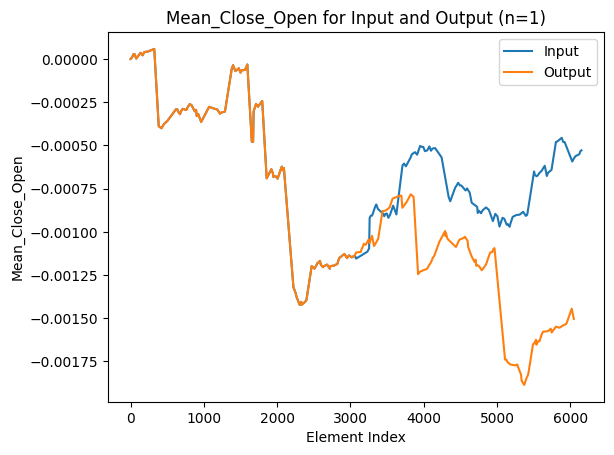

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


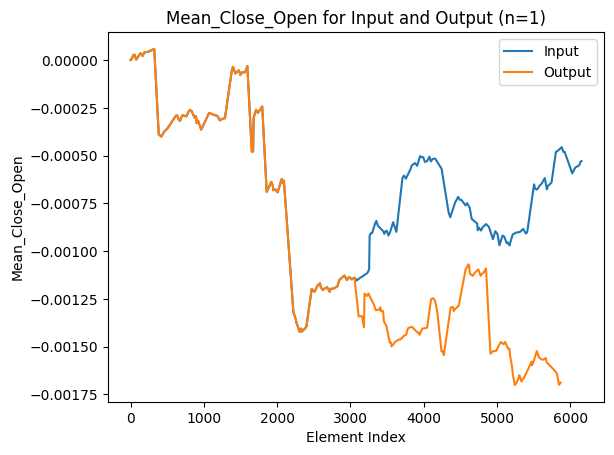

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.870081662961892e-07


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


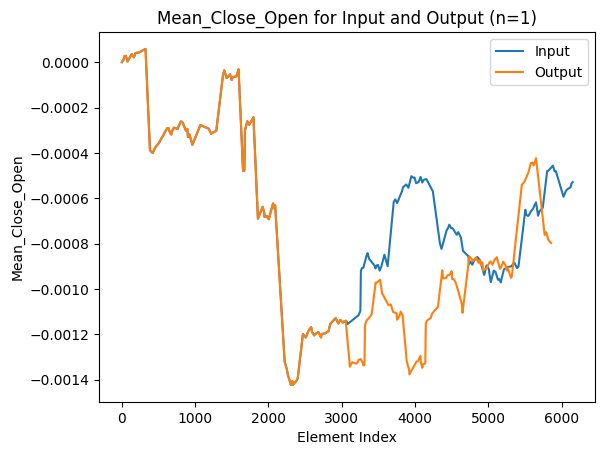

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.1866013071895393e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


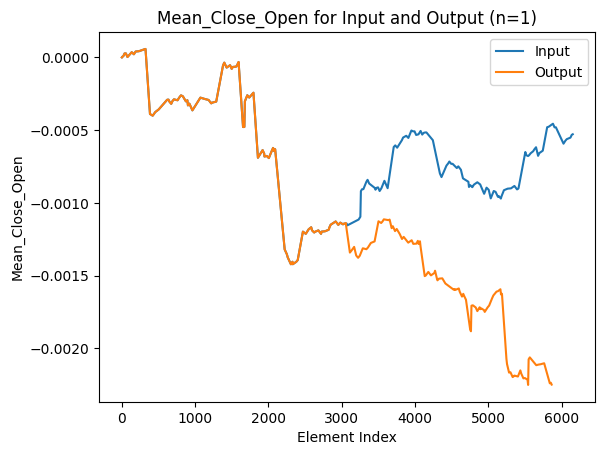

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  -5.912180656934178e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


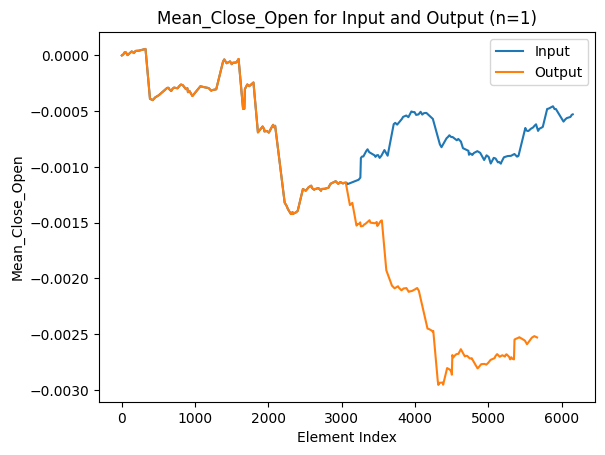

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


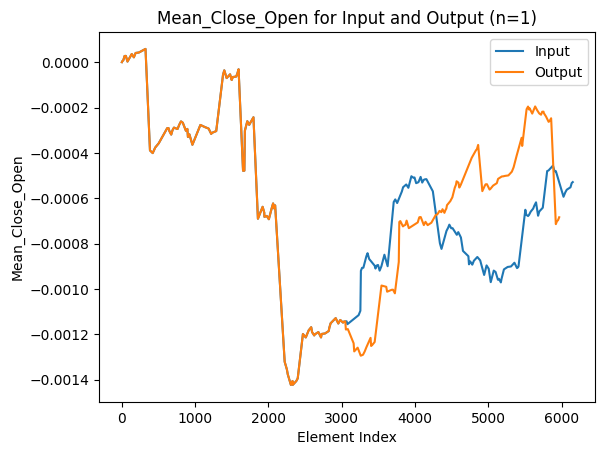

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.870081662961892e-07


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


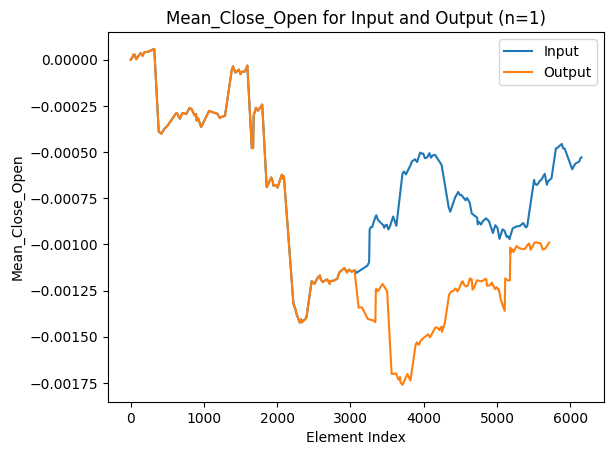

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.870081662961892e-07


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


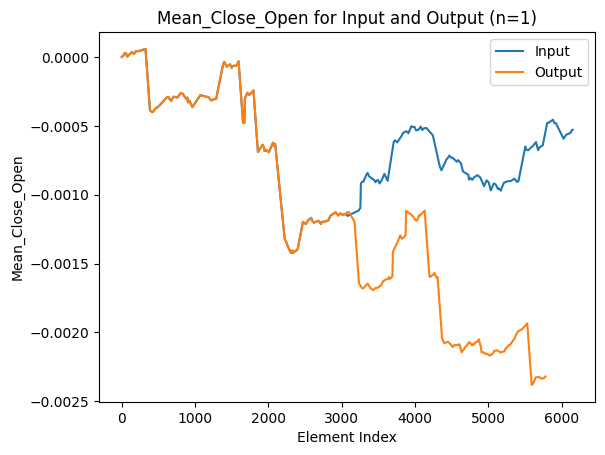

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


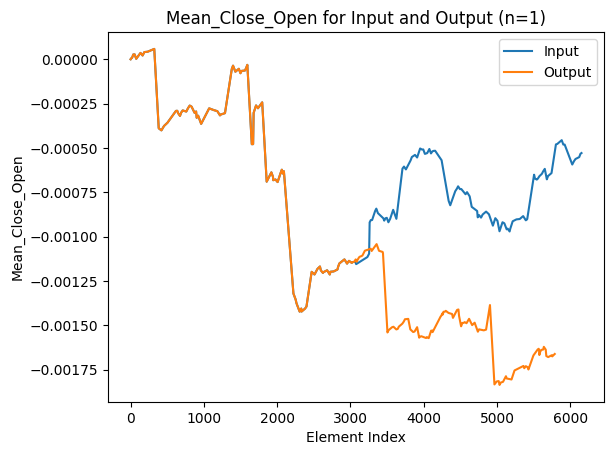

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


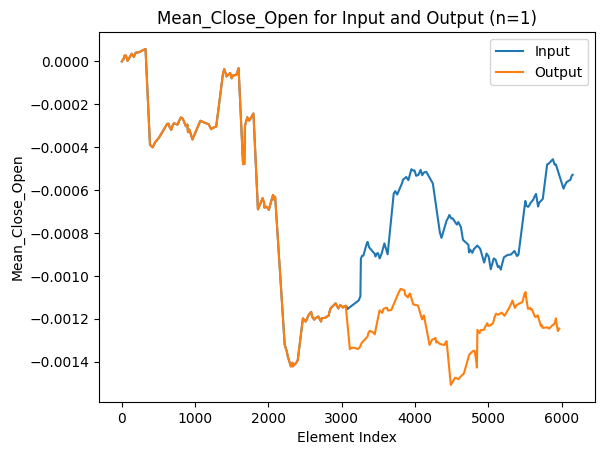

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


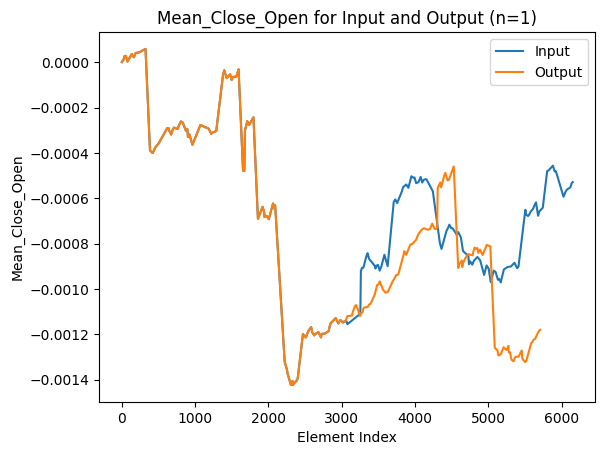

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.054494298830456e-06


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


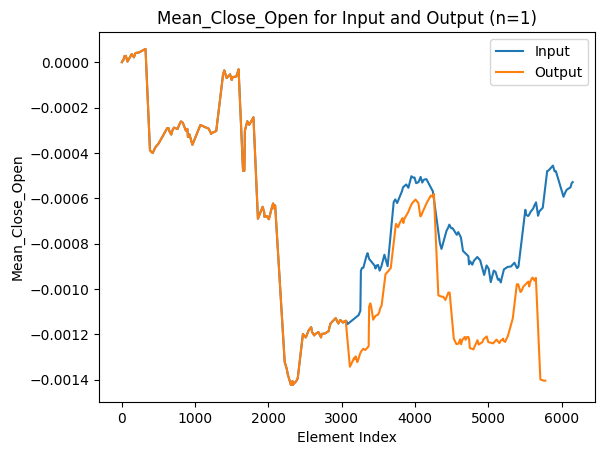

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  1.318338066058823e-05


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


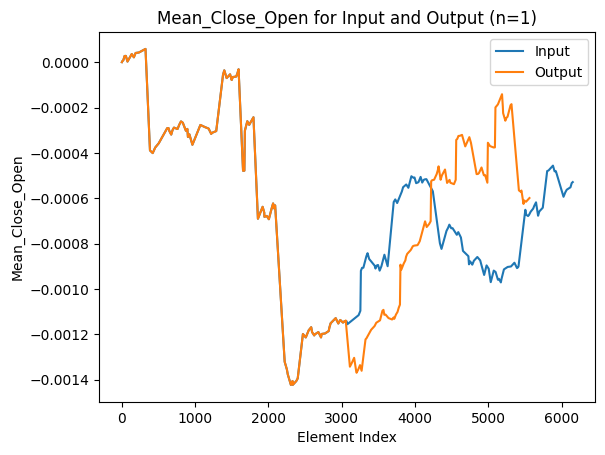

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  0.0001760828214781


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


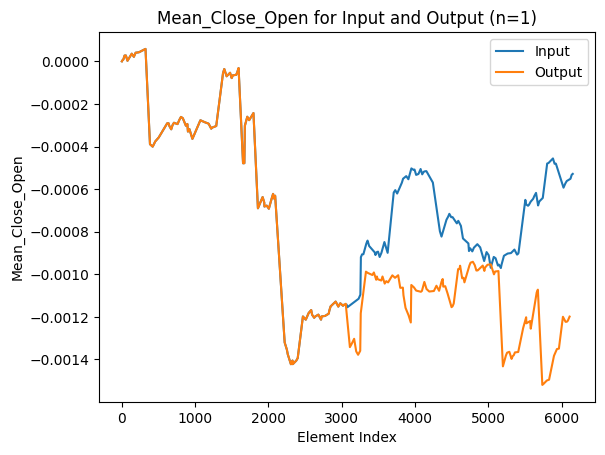

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.870081662961892e-07


<ipython-input-58-e94b6eb0a12c>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)
<ipython-input-58-e94b6eb0a12c>:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-58-e94b6eb0a12c>:102: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


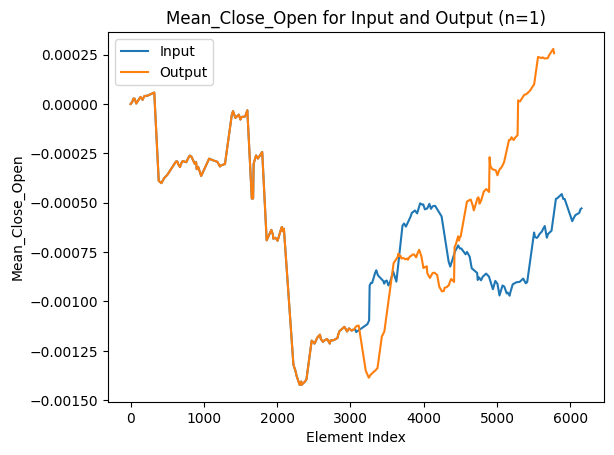

avg(y_diff) for closest word in first slice:  1.318338066058823e-05
avg(y_diff) for closest word in second slice:  4.054494298830456e-06


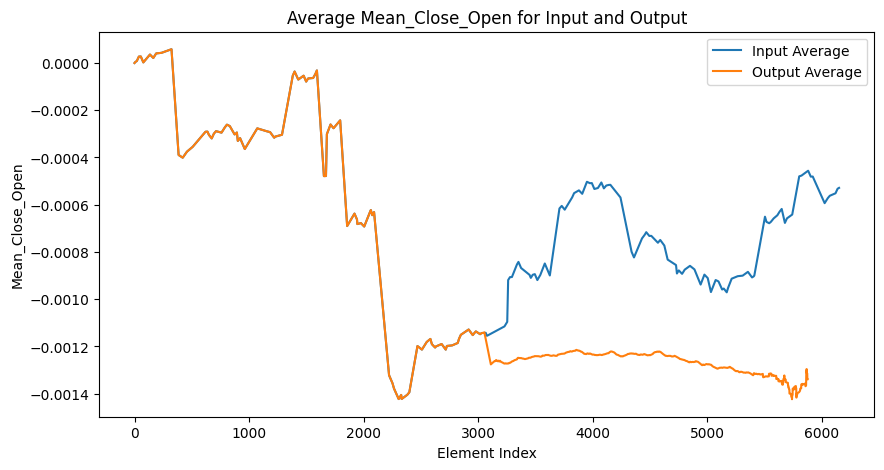

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from scipy.spatial.distance import cosine



file_path = '/content/test.txt'
with open(file_path, "r") as f:
    text = f.read()

# Загрузка файла means12.csv
means12 = pd.read_csv('/content/meangigzig20001.csv')
model.load_weights('/content/drive/MyDrive/Colab Notebooks/2001withembemb.h5')

# Получение весов слоя встраивания
embeddings = model.embedding.get_weights()[0]

# Разделение текста на номера и создание списка
numbers = text.split()
n = 1

slice_embeddings1=pd.DataFrame(columns=['first_slice_embedding', 'second_slice_embedding'])
iteration = 0
input_time_series = pd.DataFrame()
output_time_series = pd.DataFrame()
while n + 50 < len(numbers) and iteration < 1:
    for k in range(100):
      input_text = ' '.join(numbers[n:n + 100])
      states = None
      next_char = tf.constant([input_text])
      result = [next_char]

      for i in range(100):
          next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
          result.append(next_char)

      result = tf.strings.join(result, separator=' ')
        

      # use regular expressions to split the result into words
      output_text = re.findall(r'\b\w+\b', result[0].numpy().decode('utf-8'))
      #df = df.append({'input_text': input_text, 'output_text': output_text}, ignore_index=True)
      def interpolate_nan(arr):
      # Функция для интерполяции неопределенных значений
          nans = np.isnan(arr)
          arr[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), arr[~nans])
          return arr

      def process_clusters(clusters, means):
          # Функция для обработки кластеров
          points = [(0, 0)]
          for cluster in clusters:
              x_diff = round(means.loc[means['Cluster'] == cluster, 'avg(x_diff)'].values[0])
              y_diff = means.loc[means['Cluster'] == cluster, 'avg(y_diff)'].values[0]
              last_x, last_y = points[-1]
              points.append((last_x + x_diff, last_y + y_diff))
          return points

      # Преобразование номеров кластеров в значения Mean_Close_Open
      input_clusters = list(map(int, ' '.join(numbers[n:n + 200]).split()))  # Используется для вычисления input_clusters
      output_clusters = list(map(int, output_text))
      first_slice = output_clusters[:100]
      second_slice = output_clusters[-100:]
      first_slice_str = list(map(str, first_slice))
      second_slice_str = list(map(str, second_slice))

      # Получение эмбеддинга для каждого слова в срезе и их суммирование
      first_slice_embedding = sum(word2embedding.get(word, np.zeros(embeddings.shape[1])) for word in first_slice_str)
      second_slice_embedding = sum(word2embedding.get(word, np.zeros(embeddings.shape[1])) for word in second_slice_str)
    

      # Добавление сумм эмбеддингов в DataFrame
      slice_embeddings1 = slice_embeddings1.append({'first_slice_embedding': first_slice_embedding, 'second_slice_embedding': second_slice_embedding}, ignore_index=True)

      
     
      # Создание точек для input и output
      # Создание точек для input и output
      input_points = process_clusters(input_clusters, means12)
      output_points = process_clusters(output_clusters, means12)

      # Заполнение неопределенных значений средним значением двух соседних определенных точек
      input_points_x, input_points_y = zip(*input_points)
      output_points_x, output_points_y = zip(*output_points)

      input_points_x = interpolate_nan(np.array(input_points_x))
      input_points_y = interpolate_nan(np.array(input_points_y))
      output_points_x = interpolate_nan(np.array(output_points_x))
      output_points_y = interpolate_nan(np.array(output_points_y))
      
      input_series = pd.Series(index=range(max(input_points_x)+1))
      for idx, value in zip(input_points_x, input_points_y):
          input_series[idx] = value
      input_series = input_series.interpolate()  # Заполняем пустые значения

      # То же самое для output
      output_series = pd.Series(index=range(max(output_points_x)+1))
      for idx, value in zip(output_points_x, output_points_y):
          output_series[idx] = value
      output_series = output_series.interpolate()
      input_time_series['input_series_' + str(k)] = input_series
      output_time_series['output_series_' + str(k)] = output_series   
      # Отображение графика
      plt.plot(input_points_x, input_points_y, label='Input')
      plt.plot(output_points_x, output_points_y, label='Output')

    

      plt.xlabel('Element Index')
      plt.ylabel('Mean_Close_Open')
      plt.title(f'Mean_Close_Open for Input and Output (n={n})')
      plt.legend()
      plt.show()

      max_similarity_first = -1
      max_similarity_second = -1
      closest_word_first = None
      closest_word_second = None
      corresponding_y_diff_first= None
      corresponding_y_diff_second = None

      for word, embedding in word2embedding.items():
          similarity_first = 1 - cosine(first_slice_embedding, embedding)
          similarity_second = 1 - cosine(second_slice_embedding, embedding)

          if similarity_first > max_similarity_first:
              max_similarity_first = similarity_first
              closest_word_first = word

          if similarity_second > max_similarity_second:
              max_similarity_second = similarity_second
              closest_word_second = word
          
          
          if int(closest_word_first) in means12['Cluster'].values:
              corresponding_y_diff_first = means12.loc[means12['Cluster'] == int(closest_word_first), 'avg(y_diff)'].values[0]

          if int(closest_word_second) in means12['Cluster'].values:
              corresponding_y_diff_second = means12.loc[means12['Cluster'] == int(closest_word_second), 'avg(y_diff)'].values[0]
            

      print("avg(y_diff) for closest word in first slice: ", corresponding_y_diff_first)
      print("avg(y_diff) for closest word in second slice: ", corresponding_y_diff_second)
      
        #n += 1
      iteration += 1
slice_embeddings1.to_csv('/content/slice_embeddings1.csv', index=False)
input_avg = input_time_series.mean(axis=1)
output_avg = output_time_series.mean(axis=1)
plt.figure(figsize=(10,5))
plt.plot(input_avg.index, input_avg.values, label='Input Average')
plt.plot(output_avg.index, output_avg.values, label='Output Average')

plt.xlabel('Element Index')
plt.ylabel('Mean_Close_Open')
plt.title('Average Mean_Close_Open for Input and Output')
plt.legend()
plt.show()
input_time_series.to_csv('input_time_series.csv')
output_time_series.to_csv('output_time_series.csv')




In [ ]:
corresponding_y_diff_second

In [ ]:
closest_word_second 

'61'

In [ ]:
closest_word_second

'22'

In [ ]:
corresponding_y_diff_first

NameError: ignored

In [ ]:
closest_word_first 

'61'

In [ ]:
с зумом

<ipython-input-22-07e0652d3f5e>:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-22-07e0652d3f5e>:85: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


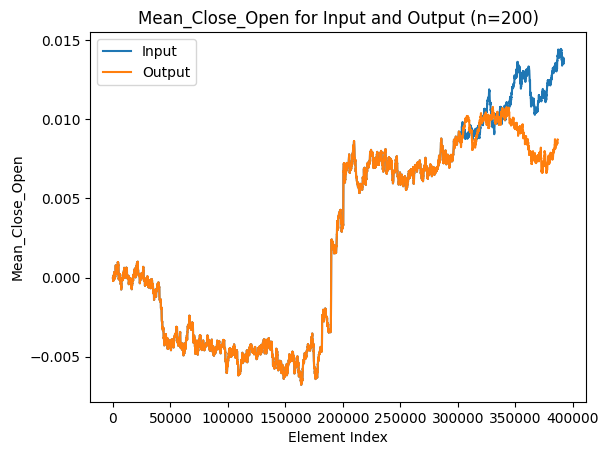

<ipython-input-22-07e0652d3f5e>:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-22-07e0652d3f5e>:85: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


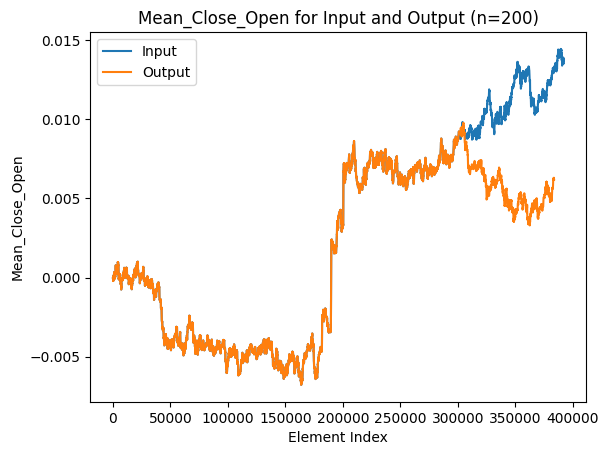

<ipython-input-22-07e0652d3f5e>:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-22-07e0652d3f5e>:85: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


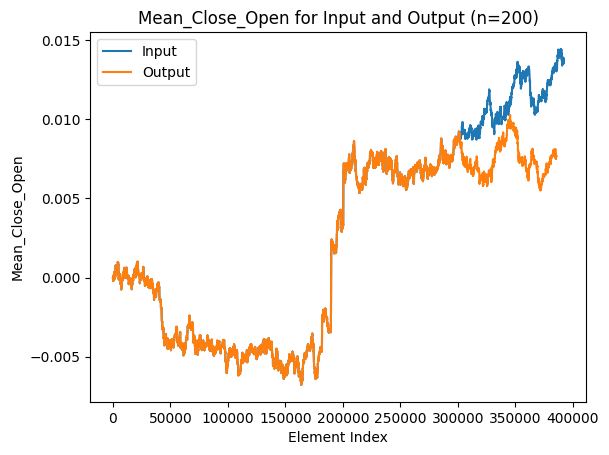

<ipython-input-22-07e0652d3f5e>:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-22-07e0652d3f5e>:85: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


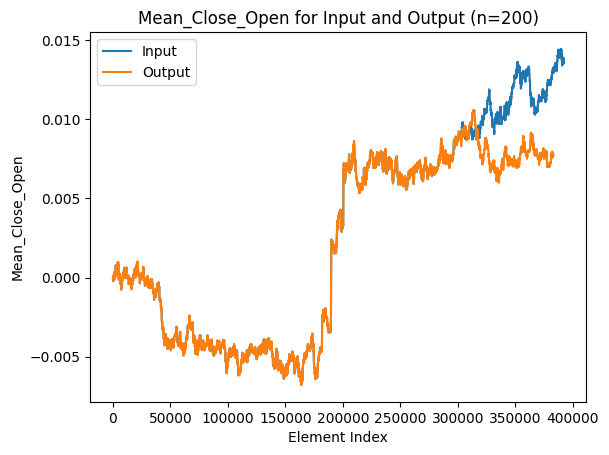

<ipython-input-22-07e0652d3f5e>:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-22-07e0652d3f5e>:85: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


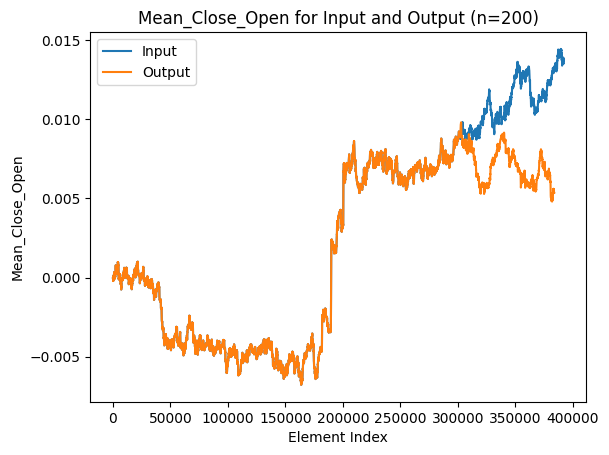

<ipython-input-22-07e0652d3f5e>:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-22-07e0652d3f5e>:85: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


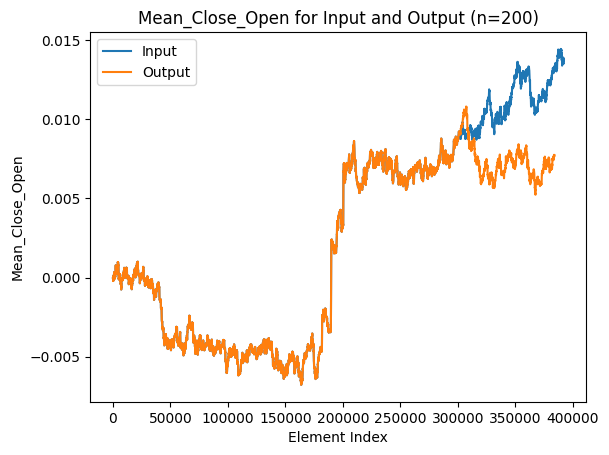

<ipython-input-22-07e0652d3f5e>:79: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  input_series = pd.Series(index=range(max(input_points_x)+1))
<ipython-input-22-07e0652d3f5e>:85: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  output_series = pd.Series(index=range(max(output_points_x)+1))


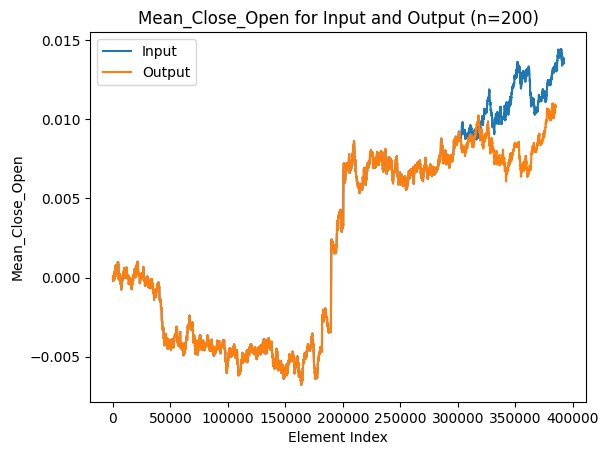

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader




file_path = '/content/test.txt'
with open(file_path, "r") as f:
    text = f.read()

# Загрузка файла means12.csv
means12 = pd.read_csv('/content/meangigzig20001.csv')


# Разделение текста на номера и создание списка
numbers = text.split()
n = 200

iteration = 0
input_time_series = pd.DataFrame()
output_time_series = pd.DataFrame()
while n + 50 < len(numbers) and iteration < 1:
    for k in range(10):
      input_text = ' '.join(numbers[n:n + 10000])
      states = None
      next_char = tf.constant([input_text])
      result = [next_char]

      for i in range(3000):
          next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
          result.append(next_char)

      result = tf.strings.join(result, separator=' ')
        

      # use regular expressions to split the result into words
      output_text = re.findall(r'\b\w+\b', result[0].numpy().decode('utf-8'))
      #df = df.append({'input_text': input_text, 'output_text': output_text}, ignore_index=True)
      def interpolate_nan(arr):
      # Функция для интерполяции неопределенных значений
          nans = np.isnan(arr)
          arr[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), arr[~nans])
          return arr

      def process_clusters(clusters, means):
          # Функция для обработки кластеров
          points = [(0, 0)]
          for cluster in clusters:
              x_diff = round(means.loc[means['Cluster'] == cluster, 'avg(x_diff)'].values[0])
              y_diff = means.loc[means['Cluster'] == cluster, 'avg(y_diff)'].values[0]
              last_x, last_y = points[-1]
              points.append((last_x + x_diff, last_y + y_diff))
          return points

      # Преобразование номеров кластеров в значения Mean_Close_Open
      input_clusters = list(map(int, ' '.join(numbers[n:n + 13000]).split()))  # Используется для вычисления input_clusters
      output_clusters = list(map(int, output_text))
      #output_clusters = output_clusters[8000:8300]
     
      # Создание точек для input и output
      # Создание точек для input и output
      input_points = process_clusters(input_clusters, means12)
      output_points = process_clusters(output_clusters, means12)

      # Заполнение неопределенных значений средним значением двух соседних определенных точек
      input_points_x, input_points_y = zip(*input_points)
      output_points_x, output_points_y = zip(*output_points)

      input_points_x = interpolate_nan(np.array(input_points_x))
      input_points_y = interpolate_nan(np.array(input_points_y))
      output_points_x = interpolate_nan(np.array(output_points_x))
      output_points_y = interpolate_nan(np.array(output_points_y))
      
      input_series = pd.Series(index=range(max(input_points_x)+1))
      for idx, value in zip(input_points_x, input_points_y):
          input_series[idx] = value
      input_series = input_series.interpolate()  # Заполняем пустые значения

      # То же самое для output
      output_series = pd.Series(index=range(max(output_points_x)+1))
      for idx, value in zip(output_points_x, output_points_y):
          output_series[idx] = value
      output_series = output_series.interpolate()
      input_time_series['input_series_' + str(k)] = input_series
      output_time_series['output_series_' + str(k)] = output_series   
      # Отображение графика
      plt.plot(input_points_x, input_points_y, label='Input')
      plt.plot(output_points_x, output_points_y, label='Output')

    

      plt.xlabel('Element Index')
      plt.ylabel('Mean_Close_Open')
      plt.title(f'Mean_Close_Open for Input and Output (n={n})')
      plt.legend()
      plt.show()
      #n += 1
      iteration += 1

input_avg = input_time_series.mean(axis=1)
output_avg = output_time_series.mean(axis=1)
plt.figure(figsize=(10,5))
plt.plot(input_avg.index, input_avg.values, label='Input Average')
plt.plot(output_avg.index, output_avg.values, label='Output Average')

plt.xlabel('Element Index')
plt.ylabel('Mean_Close_Open')
plt.title('Average Mean_Close_Open for Input and Output')
plt.legend()
plt.show()
input_time_series.to_csv('input_time_series.csv')
output_time_series.to_csv('output_time_series.csv')

In [ ]:
words_in_dictionary = word2embedding.keys()

# Печать первых 10 слов в словаре
print(list(words_in_dictionary)[:10])

['65', '5', '41', '59', '69', '20', '77', '68', '88', '35']


Empty DataFrame
Columns: [first_slice_embedding, second_slice_embedding]
Index: []

In [ ]:
second_slice_embedding 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
first_slice_embedding

0

In [ ]:
second_slice

In [ ]:
output_clusters

In [ ]:
outputs

In [ ]:
import re

In [ ]:
основное моделирование

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader


file_path = '/content/test.txt'
with open(file_path, "r") as f:
    text = f.read()

# Загрузка файла means12.csv
means12 = pd.read_csv('/content/meangigzig20001.csv')

# Разделение текста на номера и создание списка
numbers = text.split()
n = 1

iteration = 0

while n + 50 < len(numbers) and iteration < 20:
    input_text = ' '.join(numbers[n:n + 10])
    states = None
    next_char = tf.constant([input_text])
    result = [next_char]

    for i in range(10):
        next_char, states = one_step_reloaded1.generate_one_step(next_char, states=states)
        result.append(next_char)

    result = tf.strings.join(result, separator=' ')
       

    # use regular expressions to split the result into words
    output_text = re.findall(r'\b\w+\b', result[0].numpy().decode('utf-8'))
    #df = df.append({'input_text': input_text, 'output_text': output_text}, ignore_index=True)
    def interpolate_nan(arr):
    # Функция для интерполяции неопределенных значений
        nans = np.isnan(arr)
        arr[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), arr[~nans])
        return arr

    def process_clusters(clusters, means):
        # Функция для обработки кластеров
        points = [(0, 0)]
        for cluster in clusters:
            x_diff = round(means.loc[means['Cluster'] == cluster, 'avg(x_diff)'].values[0])
            y_diff = means.loc[means['Cluster'] == cluster, 'avg(y_diff)'].values[0]
            last_x, last_y = points[-1]
            points.append((last_x + x_diff, last_y + y_diff))
        return points

    # Преобразование номеров кластеров в значения Mean_Close_Open
    input_clusters = list(map(int, ' '.join(numbers[n:n + 20]).split()))  # Используется для вычисления input_clusters
    output_clusters = list(map(int, output_text))

    # Создание точек для input и output
    input_points = process_clusters(input_clusters, means12)
    output_points = process_clusters(output_clusters, means12)

    # Заполнение неопределенных значений средним значением двух соседних определенных точек
    input_points_x, input_points_y = zip(*input_points)
    output_points_x, output_points_y = zip(*output_points)

    input_points_x = interpolate_nan(np.array(input_points_x))
    input_points_y = interpolate_nan(np.array(input_points_y))
    output_points_x = interpolate_nan(np.array(output_points_x))
    output_points_y = interpolate_nan(np.array(output_points_y))

    # Отображение графика
    plt.plot(input_points_x, input_points_y, label='Input')
    plt.plot(output_points_x, output_points_y, label='Output')

   

    plt.xlabel('Element Index')
    plt.ylabel('Mean_Close_Open')
    plt.title(f'Mean_Close_Open for Input and Output (n={n})')
    plt.legend()
    plt.show()
    n += 50
    iteration += 1







NameError: ignored

In [ ]:
pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.8 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import GPT2Config, TFGPT2LMHeadModel, GPT2Tokenizer

output_dir = '/content/drive/MyDrive/model_bn_custom1'
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model2 = TFGPT2LMHeadModel.from_pretrained(output_dir)

file_path = "/content/test.txt"
with open(file_path, "r") as f:
    text = f.read()



numbers = text.split()
n = 0

df = pd.DataFrame(columns=['input_text', 'output_text'])
embeddings_df = pd.DataFrame(columns=['input_embeddings', 'output_embeddings'])

iteration = 0
correlation_df = pd.DataFrame()
n=1
while n + 50 < len(numbers) and iteration < 10:
    input_text = ' '.join(numbers[n:n + 10])
    input_text1 = ' '.join(numbers[n+10:n + 20])
    
    input_ids = tokenizer.encode(input_text, return_tensors='tf')
    input_ids1 = tokenizer.encode(input_text1, return_tensors='tf')

    with tf.GradientTape() as tape:
        # Forward pass
        outputs = model2(input_ids)
        outputs1 = model2(input_ids1)

    word_embeddings = outputs[0]  # First element of model_output contains all token embeddings
    word_embeddings1 = outputs1[0]  # First element of model_output contains all token embeddings

    summed_word_embeddings = np.sum(word_embeddings, axis=1)
    summed_word_embeddings1 = np.sum(word_embeddings1, axis=1)

    embeddings_df = embeddings_df.append({'input_embeddings': summed_word_embeddings, 'output_embeddings': summed_word_embeddings1}, ignore_index=True)
   
    n += 2
    iteration += 1
embeddings_df.to_csv('/content/drive/MyDrive/Colab Notebooks/embeddings_df.csv', index=False)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/drive/MyDrive/model_bn_custom1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
<ipython-input-7-c6749bd2a736>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embeddings_df = embeddings_df.append({'input_embeddings': summed_word_embeddings, 'output_embeddings': summed_word_embeddings1}, ignore_index=True)
<ipython-input-7-c6749bd2a736>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embeddings_df = embeddings_df.append({'input_embeddings': summed_word_embeddings, 'output_embeddings': summed_word_embeddings1}, ignore_index=True)
<ipyt

In [ ]:
input_text

'24 20 35 33 75 55 47 42 22 80'

In [ ]:
from tensorflow.keras.models import load_model

# Вернет новую модель, идентичную той, которую вы сохранили
new_model = load_model('/content/drive/MyDrive/Colab Notebooks/nero.h5')

1/1 [==============================] - 0s 46ms/step


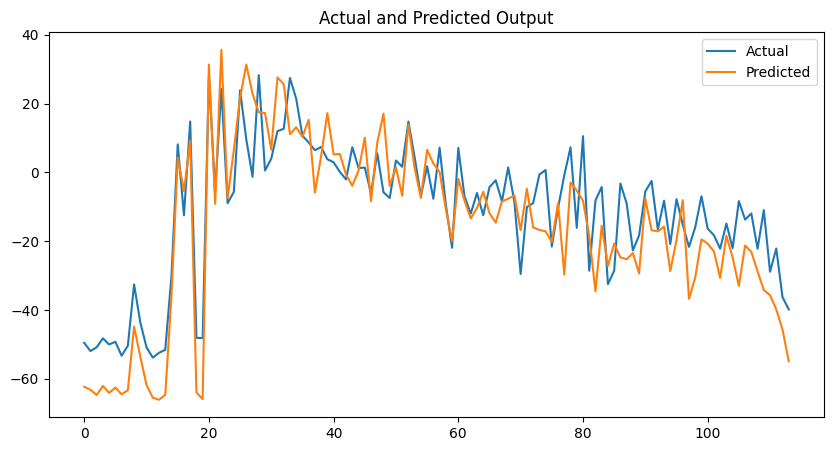

In [ ]:
input_data = np.vstack(slice_embeddings1['first_slice_embedding'].values)
output_data = np.vstack(slice_embeddings1['second_slice_embedding'].values)
# Предсказание на основе обученной модели
predictions = new_model.predict(input_data)
import matplotlib.pyplot as plt

actual_output = output_data[1]
predicted_output = predictions[1]

# Построение графика
plt.figure(figsize=(10,5))

plt.title('Actual and Predicted Output')
plt.plot(actual_output, label='Actual')
plt.plot(predicted_output, label='Predicted')

plt.legend() 

1/1 [==============================] - 0s 104ms/step


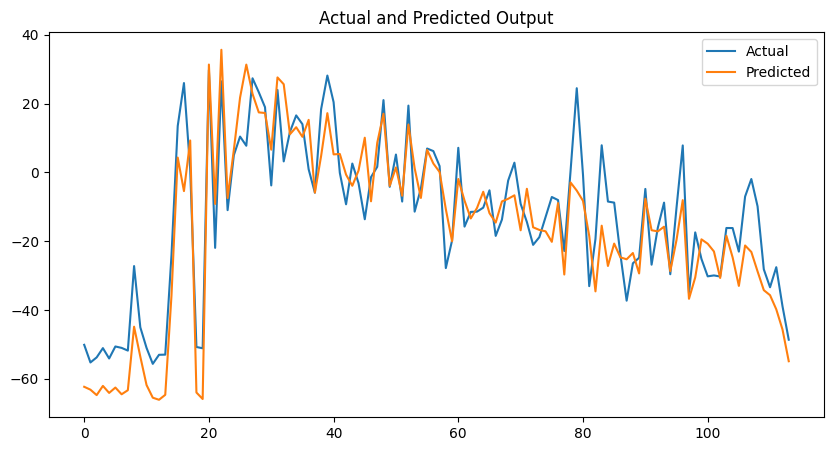

In [ ]:
input_data = np.vstack(embeddings_df['input_embeddings'].values)
output_data = np.vstack(embeddings_df['output_embeddings'].values)
# Предсказание на основе обученной модели
predictions = new_model.predict(input_data)
import matplotlib.pyplot as plt

actual_output = output_data[4]
predicted_output = predictions[4]

# Построение графика
plt.figure(figsize=(10,5))

plt.title('Actual and Predicted Output')
plt.plot(actual_output, label='Actual')
plt.plot(predicted_output, label='Predicted')

plt.legend() 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# создадим пустой DataFrame
df = pd.DataFrame(columns=['actual_output', 'predicted_output'])
input_data = np.vstack(slice_embeddings1['first_slice_embedding'].values)
output_data = np.vstack(slice_embeddings1['second_slice_embedding'].values)
predictions = new_model.predict(input_data)
# вычислим 10n значений actual_output и predicted_output
for n in range(100):  
    actual_output = output_data[n]
    predicted_output = predictions[n]
    # добавим в DataFrame
    df = df.append({'actual_output': actual_output, 'predicted_output': predicted_output}, ignore_index=True)

# Вычисляем косинусную similarity
df['similarity'] = df.apply(lambda row: cosine_similarity(row['actual_output'].reshape(1, -1), row['predicted_output'].reshape(1, -1))[0][0], axis=1)

# Сортируем DataFrame по similarity в порядке убывания
df_sorted = df.sort_values(by='similarity', ascending=False)

# выводим результат
for index, row in df_sorted.iterrows():
    print(f'Index: {index}, Similarity: {row["similarity"]}')


4/4 [==============================] - 0s 4ms/step
Index: 75, Similarity: 0.8474220037460327
Index: 40, Similarity: 0.781661868095398
Index: 96, Similarity: 0.7663373351097107
Index: 1, Similarity: 0.7655580639839172
Index: 26, Similarity: 0.763067364692688
Index: 78, Similarity: 0.7570532560348511
Index: 4, Similarity: 0.7490092515945435
Index: 66, Similarity: 0.7483934164047241
Index: 19, Similarity: 0.7470830082893372
Index: 63, Similarity: 0.7428702116012573
Index: 69, Similarity: 0.7427301406860352
Index: 72, Similarity: 0.7398422360420227
Index: 23, Similarity: 0.73841392993927
Index: 16, Similarity: 0.7361462712287903
Index: 37, Similarity: 0.7345160245895386
Index: 97, Similarity: 0.7342104911804199
Index: 33, Similarity: 0.7329261302947998
Index: 79, Similarity: 0.7302588224411011
Index: 10, Similarity: 0.7274377346038818
Index: 67, Similarity: 0.7262372970581055
Index: 17, Similarity: 0.7255970239639282
Index: 70, Similarity: 0.7233419418334961
Index: 73, Similarity: 0.723079

<ipython-input-106-f2fd2a59385f>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'actual_output': actual_output, 'predicted_output': predicted_output}, ignore_index=True)
<ipython-input-106-f2fd2a59385f>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'actual_output': actual_output, 'predicted_output': predicted_output}, ignore_index=True)
<ipython-input-106-f2fd2a59385f>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'actual_output': actual_output, 'predicted_output': predicted_output}, ignore_index=True)
<ipython-input-106-f2fd2a59385f>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

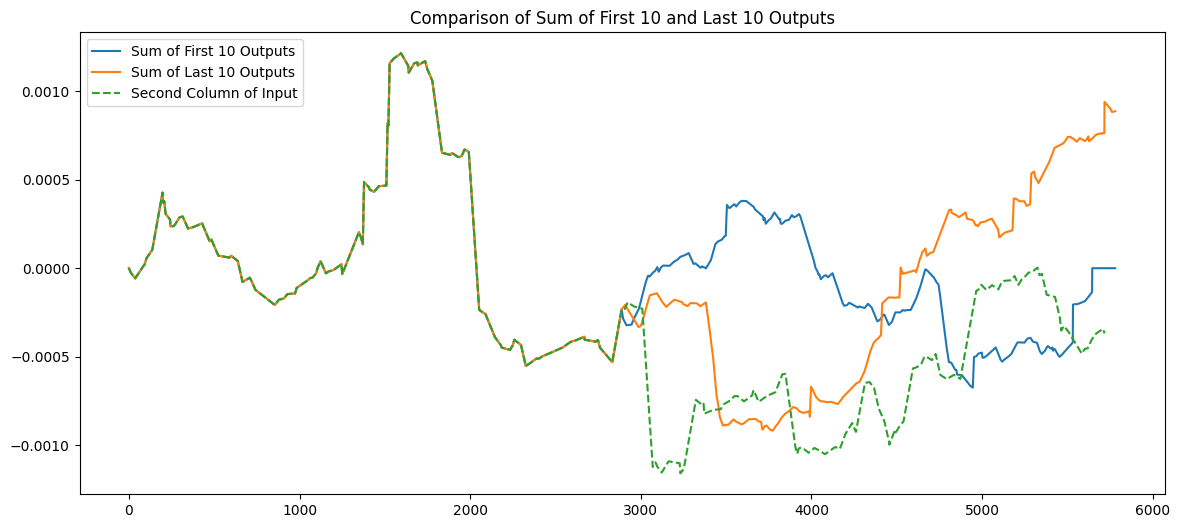

In [ ]:
# Получаем индексы из df_sorted
k=2
first_10_indexes = df_sorted.index[:k].tolist()
last_10_indexes = df_sorted.index[-k:].tolist()

# Получаем соответствующие колонки из output_time_series
first_10_columns = output_time_series[['output_series_' + str(index) for index in first_10_indexes]]
last_10_columns = output_time_series[['output_series_' + str(index) for index in last_10_indexes]]

# Суммируем колонки поэлементно
sum_first_10 = first_10_columns.sum(axis=1)
sum_last_10 = last_10_columns.sum(axis=1)

second_column_input = input_time_series.iloc[:, 1]*k
plt.figure(figsize=(14, 6))

plt.plot(sum_first_10, label='Sum of First 10 Outputs')
plt.plot(sum_last_10, label='Sum of Last 10 Outputs')
plt.plot(second_column_input, label='Second Column of Input', linestyle='--')
plt.legend(loc='best')
plt.title('Comparison of Sum of First 10 and Last 10 Outputs')
plt.show()


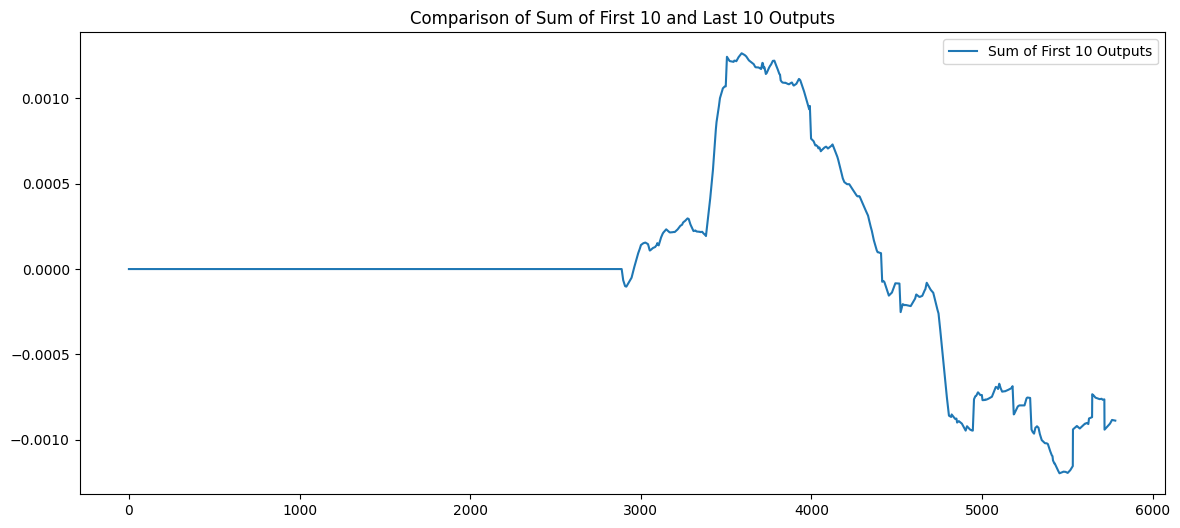

In [ ]:

sumsum=sum_first_10 - sum_last_10

plt.figure(figsize=(14, 6))

plt.plot(sumsum, label='Sum of First 10 Outputs')

plt.legend(loc='best')
plt.title('Comparison of Sum of First 10 and Last 10 Outputs')
plt.show()

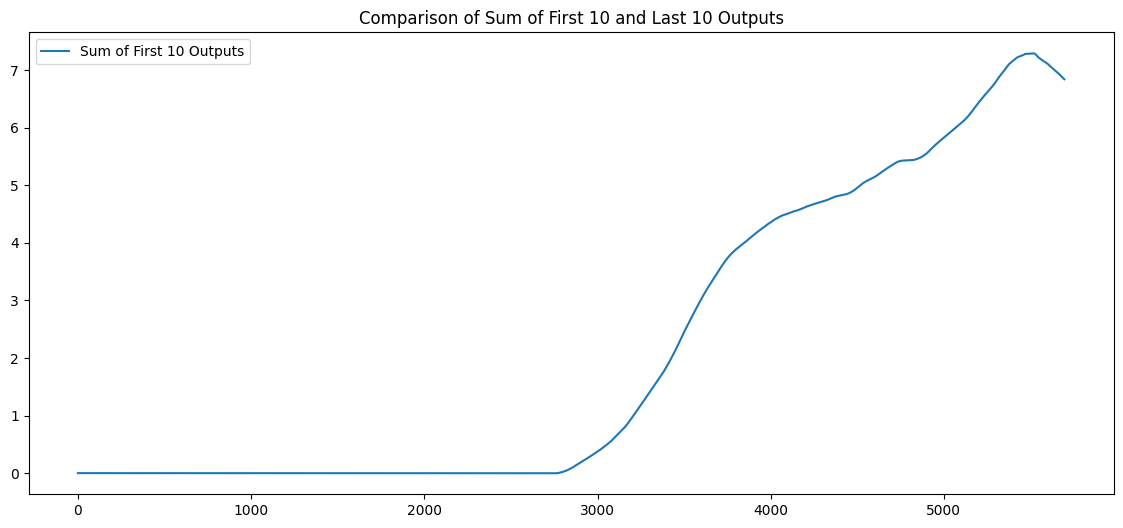

In [ ]:
cumsum = sumsum.cumsum()
plt.figure(figsize=(14, 6))

plt.plot(cumsum, label='Sum of First 10 Outputs')

plt.legend(loc='best')
plt.title('Comparison of Sum of First 10 and Last 10 Outputs')
plt.show()

In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))